- In statistics, a regression model is linear when all terms in the model are one of the following: 
   - The constant 
   - A parameter multiplied by an independent variable (IV)
- R-squared is not valid for nonlinear regression. So, you can’t use that statistic to assess the goodness-of-fit for this model. However, the standard error of the regression (S) is valid for both linear and nonlinear models and serves as great way to compare fits between these types of models. A small standard error of the regression indicates that the data points are closer to the fitted values.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
%matplotlib inline
from scipy.stats import t
from sklearn.linear_model import LinearRegression

In [5]:
# Load the Diabetes dataset
columns = "age sex bmi map tc ldl hdl tch ltg glu".split() # Declare the columns names
diabetes = datasets.load_diabetes() # Call the diabetes dataset from sklearn
df = pd.DataFrame(diabetes.data, columns=columns) # load the dataset as a pandas data frame
y = diabetes.target # define the target variable (dependent variable) as y

In [6]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(353, 10) (353,)
(89, 10) (89,)


In [7]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predictions')

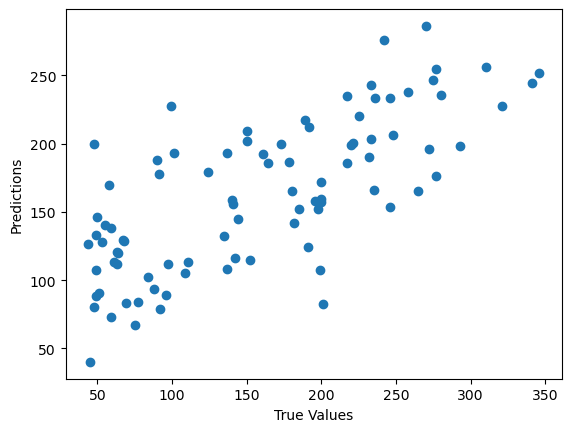

In [9]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [10]:
print ("Score: ", model.score(X_test, y_test))

Score:  0.5221909495309836


-  **Model does not adequately fit curvature in data.**
  - Curved patterns in residuals vs variables plot
  - Possible solutions
    - Use polynomials or inverses to fit curves using OLS 
    - Use Nonlinear regression to fit a wider variety of curves 
    - Data transformation (e.g., log)
- **Heteroscedasticity: Residuals do not have a constant variance**
 - Fan shape in residuals vs fits plot
 - Possible solutions
   - Redefine IVs to focus on rates,per capita, etc. rather than raw measure 
   - Weighted least squares 
   - Data transformation
- **Autocorrelation: Residuals are correlated with adjacent residuals**
 - Patterns in residuals vs order plot 
 - Durbin-Watson statistic
 - Possible solutions
   - Add lag variable, which are past values of the IVs 
   - Add independent variable to include time information 
   - Time series analysis
- **Residuals do not follow normal distribution**
 - Normal plot of residuals 
 - Histogram
 - Normality test
 - Possible solutions
   - Specify correct model 
   - Check for outliers 
   - Use Generalized Linear Models (GLM) regression which allows for other error distributions
   - Data transformation and then use OLS

- **Individual observations that are unusual and strongly influence the model**
 - Residual plots 
 - Fit model with and without observations to observe how it affects model estimates 
 - DFITS 
 - Cook's distance
 - Leverages
 - Possible solutions
   - Remove unusual observations when they don’t reflect your study area. 
   - Or, include model with and without observations in your report and discuss.
- **Multicollinearity: Independent variables are correlated**
 - Variance inflation factors (VIF) greater than 5 
 - Coefficients with unexpected signs
 - Possible solutions
   - Remove independent variable 
   - Linear combination of variables 
   - Use PLS, LASSO, or Ridge regression


**Prediction interval**
- A prediction interval is a range where a single new observation is likely to fall given values of the independent variable(s) that you specify. These ranges incorporate the margin of error around the predicted value. If the prediction intervals are too wide, the predictions don’t provide useful information.
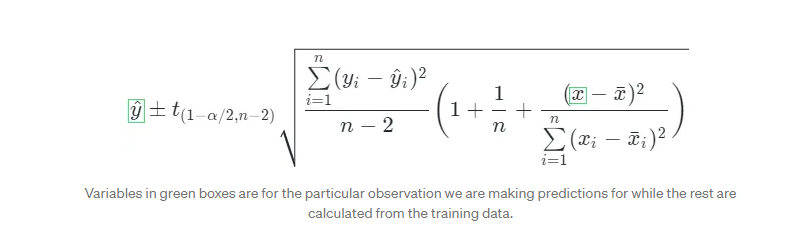

In [13]:
class CustomLinearRegression:
    def __init__(self):
        pass
    
    def fit(self, x, y):
        # Calculate stats
        self.n = len(x)
        self.x_mean = np.mean(x)
        self.y_mean = np.mean(y)
        self.x_gap = x-self.x_mean
        self.y_gap = y-self.y_mean
        self.ss = np.square(self.x_gap).sum()
        
        # Find coefficients
        self.slope = np.dot(self.x_gap, self.y_gap)/self.ss
        self.intercept = self.y_mean-self.slope*self.x_mean
        
        # Find training error
        y_pred = self.intercept+self.slope*x
        self.se_regression = np.sqrt(
            np.square(y-y_pred).sum()/(self.n-2)
        )
    
    def predict(self, x):
        y_pred = self.intercept+self.slope*x
        return y_pred
    
    def predict_interval(self, x, alpha=0.1):
        t_stat = t.ppf(1-alpha/2, df=self.n-2)
        
        # Calculate interval upper and lower boundaries
        df = pd.DataFrame({'x': x})
        for i, value in df['x'].iteritems():
            se = self.se_regression * np.sqrt(
                1+1/self.n+np.square(value-self.x_mean)/self.ss
            )
            df.loc[i, 'y_pred'] = self.intercept+self.slope*value
            df.loc[i, 'lower'] = df.loc[i, 'y_pred']-t_stat*se
            df.loc[i, 'upper'] = df.loc[i, 'y_pred']+t_stat*se
        return df
        

In [36]:
df = pd.read_csv('sheet2.csv')
df.head()

x  y  y_hat
0  1  2    2.2
1  2  5    4.4
2  3  6    6.6
3  4  9    8.8

In [39]:
#define response variable
y = df['y']

#define explanatory variable
x = df['x']

In [40]:
custom_model = CustomLinearRegression()     
custom_model.fit(x, y)
print(f"Intercept: {custom_model.intercept:.2f}")
print(f"Slope: {custom_model.slope:.2f}")
custom_pred = custom_model.predict_interval(x)
custom_pred.head()

Intercept: 0.00
Slope: 2.20


x  y_pred     lower      upper
0  1     2.2 -0.207882   4.607882
1  2     4.4  2.294368   6.505632
2  3     6.6  4.494368   8.705632
3  4     8.8  6.392118  11.207882

- Let’s understand this output. In linear regression, predictions represent conditional mean target value. So y_pred, our prediction column, tells us the estimated mean target given the features. Prediction intervals tell us a range of values the target can take for a given record. We can see the lower and upper boundary of the prediction interval from lower and upper columns. This is a 90% prediction interval because we chose alpha=0.1. 
  - There is 90% probability that the actual target value for record 0 will be between -0.20 and 4.6.
  - We are 90% confident that the actual target value for for record 0 will fall somewhere between -0.20 and 4.6 based on their x value.
  - Approximately 90% of prediction intervals will contain the actual value.

In [52]:
df['intercept'] = 1
df.head()

x  y  y_hat  intercept
0  1  2    2.2          1
1  2  5    4.4          1
2  3  6    6.6          1
3  4  9    8.8          1

In [56]:
lm2 = sm.OLS(df['y'], df[['x', 'intercept']])
results = lm2.fit()
results.summary()

C:\Users\SumeetAbhu\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     60.50
Date:                Wed, 17 May 2023   Prob (F-statistic):             0.0161
Time:                        17:42:38   Log-Likelihood:                -2.4569
No. Observations:                   4   AIC:                             8.914
Df Residuals:                       2   BIC:                             7.686
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.2000      0.283      7.778      0.016       0.983       3.417
intercept   8.882e-16      0.775   1.15e-15      1.000      -3.333       3.333
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.400
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.308
Skew:                           0.000   Prob(JB):                        0.857
Kurtosis:                       1.640   Cond. No.                         7.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
predictions = results.get_prediction(df[['x', 'intercept']])
predictions.summary_frame(alpha=0.1)

mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0   2.2  0.52915       0.654889       3.745111     -0.207882      4.607882
1   4.4  0.34641       3.388487       5.411513      2.294368      6.505632
2   6.6  0.34641       5.588487       7.611513      4.494368      8.705632
3   8.8  0.52915       7.254889      10.345111      6.392118     11.207882

- This output provides some additional outputs, let’s understand the key ones:
  - mean: Prediction, same as y_pred from earlier.
  - mean_ci_lower & mean_ci_upper: Confidence interval boundaries
    - Confidence intervals are for mean predictions. Unlike prediction interval, confidence interval doesn’t tell us a range of target values an observation can take. Instead, it tells us a range of target mean values. Here’s an example interpretation: There is 90% probability that mean target value for records with feature values same as record 0 will fall somewhere between 0.65 and 3.7.
  - obs_ci_lower & obs_ci_upper: Prediction interval boundaries, same as lower and upper from earlier.
  - While both intervals are centred around the prediction, the standard errors for prediction intervals is bigger than the one for confidence intervals. As a result, prediction intervals are wider than confidence intervals.

**Model Assumptions**
1. **Linearity**
- The assumption of linearity is that a linear model is a relationship that truly exists between your response and predictor variables. If this isn't true, then your predictions will not be very accurate. 
- Additionally, the linear relationships associated with your coefficients really aren't useful either.In order to assess if a linear relationship is reasonable, a plot of the residuals $(y− \hat{y})$ by the predicted values $\hat{y}$ is often useful. If there are curvature patterns in this plot, it suggests that a linear model might not actually fit the data, and some other relationship exists between the predictor variables and response. There are many ways to create non-linear models (even using the linear model form- The first and simplest solutions I’d try are adding variables, using a different technique to model the curvature, and adding interaction terms. )
- Ideally, we want to see a random scatter of points like the top left residual plot in the image
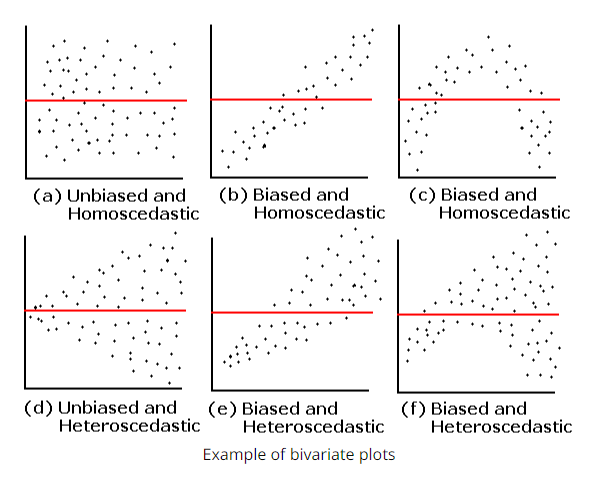

2. **Correlated Errors**:
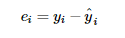
- One observation of the error term should not predict the next observation. For instance, if the error for one observation is positive and that systematically increases the probability that the following error is positive, that is a positive correlation. If the subsequent error is more likely to have the opposite sign, that is a negative correlation. This problem is known both as serial correlation and autocorrelation. Serial correlation is most likely to occur in time series models.
- Assess this assumption by graphing the residuals in the order that the data were collected. You want to see randomness in the plot.
- As I’ve explained, if you have information that allows you to predict the error term for an observation, you must incorporate that information into the model itself. To resolve this issue, you might need to add an independent variable to the model that captures this information. Analysts commonly use distributed lag models, which use both current values of the dependent variable and past values of independent variables.
- Correlated errors frequently occur when our data are collected over time (like in forecasting stock prices or interest rates in the future) or data are spatially related (like predicting flood or drought regions). We can often improve our predictions by using information from the past data points (for time) or the points nearby (for space).
- The main problem with not accounting for correlated errors is that you can often use this correlation to your advantage to better predict future events or events spatially close to one another.
- One of the most common ways to identify if you have correlated errors is based on the domain from which the data were collected. If you are unsure, there is a test known as a Durbin-Watson test that is commonly used to assess whether the correlation of the errors is an issue. Then ARIMA or ARMA models are commonly implemented to use this correlation to make better predictions.

3. **Non-constant Variance and Normally Distributed Errors**
- Heteroscedasticity means unequal scatter. In regression analysis, we talk about heteroscedasticity in the context of the residuals or error term. Specifically, heteroscedasticity is a systematic change in the spread of the residuals over the range of measured values. Heteroscedasticity is a problem because ordinary least squares (OLS) regression assumes that all residuals are drawn from a population that has a constant variance (homoscedasticity).
- **What Causes Heteroscedasticity?**: Heteroscedasticity, also spelled heteroskedasticity, occurs more often in datasets that have a large range between the largest and smallest observed values. While there are numerous reasons why heteroscedasticity can exist, a common explanation is that the error variance changes proportionally with a factor. This factor might be a variable in the model. In some cases, the variance increases proportionally with this factor but remains constant as a percentage. For instance, a 10% change in a number such as 100 is much smaller than a 10% change in a large number such as 100,000. In this scenario, you expect to see larger residuals associated with higher values. That’s why you need to be careful when working with wide ranges of values!
- **Pure heteroscedasticity** refers to cases where you specify the correct model and yet you observe non-constant variance in the residual plots. 
- **Impure heteroscedasticity** refers to cases where you incorrectly specify the model, and that causes the non-constant variance. When you leave an important variable out of a model, the omitted effect is absorbed into the error term. If the effect of the omitted variable varies throughout the observed range of data, it can produce the telltale signs of heteroscedasticity in the residual plots.
- Non-constant variance is when the spread of your predicted values differs depending on which value you are trying to predict. This isn't a huge problem in terms of predicting well. However, it does lead to confidence intervals and p-values that are inaccurate. Confidence intervals for the coefficients will be too wide for areas where the actual values are closer to the predicted values but too narrow for areas where the actual values are more spread out from the predicted values.
- Heteroscedasticity tends to produce p-values that are smaller than they should be. This effect occurs because heteroscedasticity increases the variance of the coefficient estimates but the OLS procedure does not detect this increase. Consequently, OLS calculates the t-values and F-values using an underestimated amount of variance. This problem can lead you to conclude that a model term is statistically significant when it is actually not significant.
- Non-constant variance can be assessed again using a plot of the residuals by the predicted values. In the image at the bottom of the page, non-constant variance is labeled as heteroscedastic. Ideally, we want an unbiased model with homoscedastic residuals (consistent across the range of values).
- The easiest way to **check this assumption** is to create a residuals versus fitted values plot. On this type of graph, heteroscedasticity appears as a cone shape where the spread of the residuals increases in one direction.


- **How to Fix Heteroscedasticity**
  - Redefining the variables:If your model is a cross-sectional model that includes large differences between the sizes of the observations, you can find different ways to specify the model that reduces the impact of the size differential. To do this, change the model from using the raw measure to using rates and per capita values.
  - Weighted least squares regression: Weighted least squares regression is a method that assigns each data point a weight based on the variance of its fitted value. The idea is to give small weights to observations associated with higher variances to shrink their squared residuals. Weighted regression minimizes the sum of the weighted squared residuals. When you use the correct weights, heteroscedasticity is replaced by homoscedasticity. I prefer this approach somewhat less than redefining the variables. For one thing, weighted regression involves more data manipulation because it applies the weights to all variables.
    -  For our data, we know that higher populations are associated with higher variances. Consequently, we need to assign lower weights to observations of large populations. Finding the theoretically correct weight can be difficult. However, when you can identify a variable that is associated with the changing variance, a common approach is to use the inverse of that variable as the weight.
    - For weighted regression, it is important to assess the standardized residuals because only that type of residual will show us that weighted regression fixed the heteroscedasticity.
  - Transform the dependent variable:Commonly, a log (or some other transformation of the response variable is done) in order to "get rid" of the non-constant variance. In order to choose the transformation, a Box-Cox is commonly used.
    - For example, the most common transformation is probably the natural log—which is denoted as log or ln. Here’s how it works. The natural log is $e^x$, where e equals ~2.718. When transforming your data using the natural log, the software calculates the power by which to raise 2.718 that produces the original value. The power becomes the transformed value for that original value. Suppose the original value is 10. Your software calculates X in the following: $2.718^X$ = 10. In this case, X is the new data point, and it equals 2.302585093 because $2.718^{2.302585093}$ = 10. The software repeats this process for the all the values of a variable. Taking the square root is another common transformation. For example, if your original data point is 9, the square root transformed value is 3.

**Box-Cox Transformation**
- A box-cox transformation is a commonly used method for transforming a non-normally distributed dataset into a more normally distributed one.
- The basic idea behind this method is to find some value for λ such that the transformed data is as close to normally distributed as possible, using the following formula:

  - y(λ) = $(y^λ – 1) / λ$  if y ≠ 0
  - y(λ) = log(y)  if y = 0
- You cannot use the Box-Cox transformation when your data contain zero or negative values.


<AxesSubplot:ylabel='Density'>

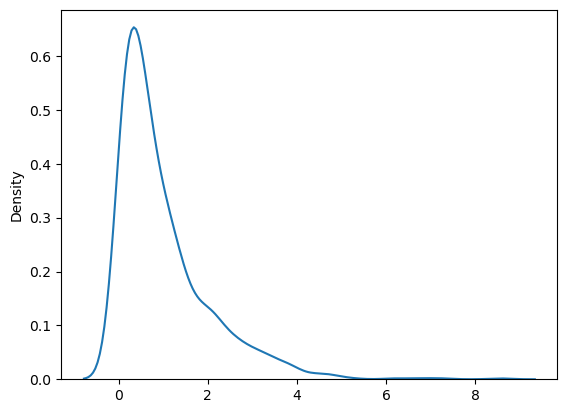

In [57]:
#load necessary packages
import numpy as np 
from scipy.stats import boxcox 
import seaborn as sns 

#make this example reproducible
np.random.seed(0)

#generate dataset
data = np.random.exponential(size=1000)

#plot the distribution of data values
sns.kdeplot(data) 

<AxesSubplot:ylabel='Density'>

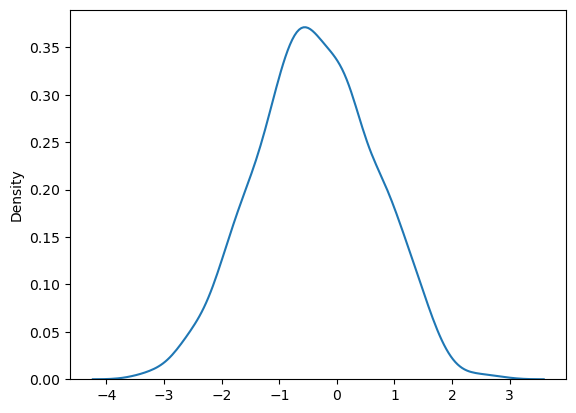

In [58]:
#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(data) 

#plot the distribution of the transformed data values
sns.kdeplot(transformed_data) 

In [28]:
#display optimal lambda value
print(best_lambda)

0.2420131978174143

0.2420131978174143


0.2420131978174143

In [38]:
New = ((0.795**0.242) - 1) / 0.242
New

-0.22316111954009335

In [39]:
#view first five values of original dataset
data[0:5]

array([0.79587451, 1.25593076, 0.92322315, 0.78720115, 0.55104849])

In [32]:
#view first five values of transformed dataset
transformed_data[0:5]

array([-0.22212062,  0.23427768, -0.07911706, -0.23247555, -0.55495228])

**Johnson Transformation**
- The Johnson transformation uses a different algorithm than the Box-Cox transformation. This transformation function selects from three families of functions by changing their parameters. It is a more powerful transformation than the Box-Cox transformation, and it can usually find an acceptable transformation. Additionally, you can use the Johnson transformation when your data have zero or negative values.


<AxesSubplot:ylabel='Density'>

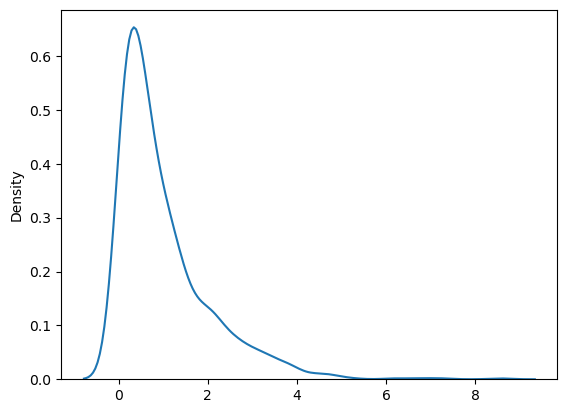

In [45]:
#load necessary packages
import numpy as np 
from scipy.stats import boxcox 
import seaborn as sns 

#make this example reproducible
np.random.seed(0)

#generate dataset
data = np.random.exponential(size=1000)

#plot the distribution of data values
sns.kdeplot(data) 

In [52]:
from scipy import stats
transformed_data, best_lambda = stats.yeojohnson(data)

<AxesSubplot:ylabel='Density'>

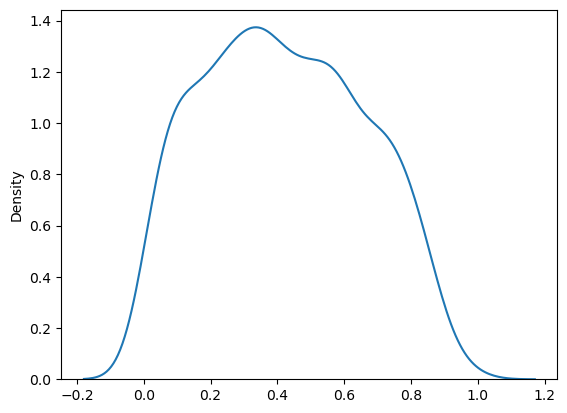

In [54]:
#plot the distribution of data values
sns.kdeplot(transformed_data) 

In [56]:
#display optimal lambda value
print(best_lambda)

-0.8665802564986734


- **How to Interpret the Results for Transformed Data**
- When you transform the data and fit a model, the statistical results apply to the transformed data rather than the original data. You describe the relationship as you would for untransformed data but including information about the transformed variable(s). For example, if there is a positive relationship between Input and Output, but you used a natural log transformation on Output, you’d state that there is a positive, linear relationship between Input and the natural log of the Output. 
- In other words, as Input increases, the expected natural log of the Output also increases. If you transformed both Input and Output, you state that there is a positive, linear relationship between the natural log of Input and the natural log of the Output. In that manner, some aspects of the interpretation remain similar. However, be aware that the coefficients, predictions, and prediction intervals all correspond to the transformed data. If you graph the results on a fitted line plot, the line follows the transformed data. Interpreting the results is less intuitive! Even the graph, which usually brings that data to life, won’t look anything like the real data!
- You can manually back transform the values (coefficients, predictions, etc.) to obtain them in their natural units. Alternatively, some statistical software can back convert the values for you automatically. While this is convenient, I always find that it still requires extra work to understand what the relationships really look like.
- Additionally, if you transform the dependent variable, it changes the variance structure of the Y-variable and the residuals. Goodness-of-fit statistics,statistics, such as R-squared and the standard error of the regression (S), apply to the transformed data rather than the raw data. Additionally, you can’t compare these statistics between models with untransformed and transformed dependent variables. Furthermore, the standard error of the mean is in the units of the transformed variable rather than natural units. You can’t back transform S because it is likely to change over the range of the fitted values.


4. **Outliers/Leverage Points**
- Outliers and leverage points are points that lie far away from the regular trends of your data. These points can have a large influence on your solution. In practice, these points might even be typos. If you are aggregating data from multiple sources, it is possible that some of the data values were carried over incorrectly or aggregated incorrectly.
- Other times outliers are accurate and true data points, not necessarily measurement or data entry errors. In these cases, 'fixing' is more subjective. Often the strategy for working with these points is dependent on the goal of your analysis. Linear models using ordinary least squares, in particular, are not very robust. That is, large outliers may greatly change our results. There are techniques to combat this - largely known as regularization techniques.
1. **Outliers (Unusual Y-values)**: 
  - Consider that a residual of 10 might be considered small in one model but very large in another. It depends on the units of measurement, the variability in the data, and the overall fit of the model. How do you determine whether a residual of 10 is large? It’s much easier to use internally studentized residuals, also known as standardized residuals. **Standardized residuals** take the raw residual value and divide it by the standard deviation of the residuals. Consequently, studentized residuals tell you how many standard deviations the observed value falls from the fitted value. For example, if the raw residual is 9 and its standard deviation is 3, the standardized residual equals 3.
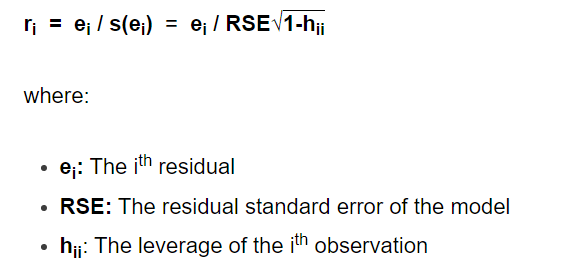
  - Typically, a standardized residual of +/- 3, or more, is a common benchmark for identifying large residuals that you should investigate. These residuals are at least three standard deviations away from the predicted value. When there are no underlying problems, you’d expect approximately 1 out of every 100 observations to have standardized residuals that are at least as extreme as +/- 3. High studentized residuals don’t necessarily indicate that there is a problem, but you should look into them.
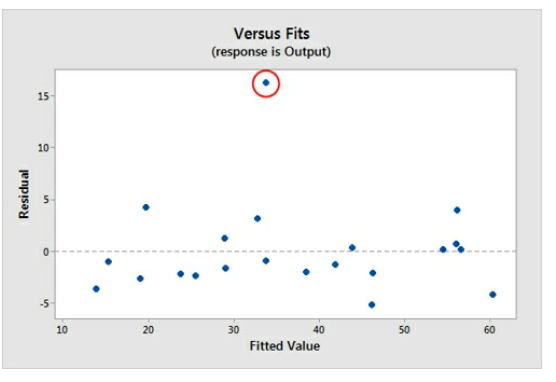


In [2]:
df = pd.read_csv('sheet2.csv')
df.head()

x  y  y_hat
0  1  2    2.2
1  2  5    4.4
2  3  6    6.6
3  4  9    8.8

In [3]:
df['residuals']= df['y']- df['y_hat']
df

x  y  y_hat  residuals
0  1  2    2.2       -0.2
1  2  5    4.4        0.6
2  3  6    6.6       -0.6
3  4  9    8.8        0.2

In [4]:
df['diff']= df['x']-df['x'].mean()

In [5]:
df['diff_square']= df['diff']**2
df

x  y  y_hat  residuals  diff  diff_square
0  1  2    2.2       -0.2  -1.5         2.25
1  2  5    4.4        0.6  -0.5         0.25
2  3  6    6.6       -0.6   0.5         0.25
3  4  9    8.8        0.2   1.5         2.25

In [6]:
(1-df['x'].mean())**2

2.25

In [7]:
df['diff_square'].sum()

5.0

In [8]:
h_i= (1/4) + (2.25/5) # (14,68)
h_i

0.7

In [9]:
df['h_i']= [0.7, 0.3,0.3,0.7]
df

x  y  y_hat  residuals  diff  diff_square  h_i
0  1  2    2.2       -0.2  -1.5         2.25  0.7
1  2  5    4.4        0.6  -0.5         0.25  0.3
2  3  6    6.6       -0.6   0.5         0.25  0.3
3  4  9    8.8        0.2   1.5         2.25  0.7

In [10]:
df['standardized residuals']= [-0.57735, 1.13389, -1.13389,0.57735]
df

x  y  y_hat  residuals  diff  diff_square  h_i  standardized residuals
0  1  2    2.2       -0.2  -1.5         2.25  0.7                -0.57735
1  2  5    4.4        0.6  -0.5         0.25  0.3                 1.13389
2  3  6    6.6       -0.6   0.5         0.25  0.3                -1.13389
3  4  9    8.8        0.2   1.5         2.25  0.7                 0.57735

In [11]:
def rse(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    differences = np.subtract(actual, predicted)
    squared_differences = np.square(differences)
    return squared_differences

In [12]:
(rse(df['y'],df['y_hat']).sum()) / (4-2)

0.3999999999999995

In [13]:
import statsmodels.api as sm

#define response variable
y = df['y']

#define explanatory variable
x = df['x']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit() 


#create instance of influence
influence = model.get_influence()

#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal

#display standardized residuals
print(standardized_residuals)

[-0.57735027  1.13389342 -1.13389342  0.57735027]


2. **Studentized Residuals**
- When trying to identify outliers, one problem that can arise is when there is a potential outlier that influences the regression model to such an extent that the estimated regression function is "pulled" towards the potential outlier, so that it isn't flagged as an outlier using the standardized residual criterion. To address this issue, studentized residuals offer an alternative criterion for identifying outliers. The basic idea is to delete the observations one at a time, each time refitting the regression model on the remaining n–1 observations. Then, we compare the observed response values to their fitted values based on the models with the ith observation deleted. This produces deleted residuals. Standardizing the deleted residuals produces studentized residuals.
- In general, studentized residuals are going to be more effective for detecting outlying Y observations than standardized residuals. If an observation has a studentized residual that is larger than 3 (in absolute value) we can call it an outlier. 

In [2]:
df = pd.read_csv('sheet2.csv')
df.head()

x  y  y_hat
0  1  2    2.2
1  2  5    4.4
2  3  6    6.6
3  4  9    8.8

In [3]:
import statsmodels.api as sm

#define response variable
y = df['y']

#define explanatory variable
x = df['x']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit() 

#calculate studentized residuals
stud_res = model.outlier_test()

#display studentized residuals
print(stud_res)

   student_resid   unadj_p  bonf(p)
0      -0.447214  0.732280      1.0
1       1.341641  0.407769      1.0
2      -1.341641  0.407769      1.0
3       0.447214  0.732280      1.0


Text(0, 0.5, 'Studentized Residuals')

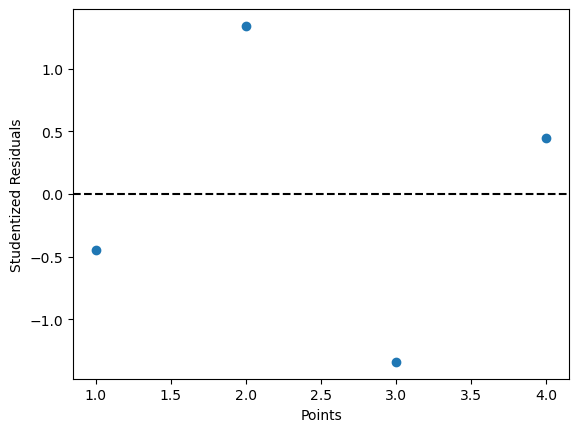

In [5]:
import matplotlib.pyplot as plt

#define predictor variable values and studentized residuals
x = df['x']
y = stud_res['student_resid']

#create scatterplot of predictor variable vs. studentized residuals
plt.scatter(x, y)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Points')
plt.ylabel('Studentized Residuals') 

- Now we just have to decide if this is large enough to deem the data point influential. To do that we rely on the fact that, in general, studentized residuals follow a t distribution with (n–k–2) degrees of freedom. That is, all we need to do is compare the studentized residuals to the t distribution with (n–k–2) degrees of freedom. If a data point's studentized residual is extreme—that is, it sticks out like a sore thumb—then the data point is deemed influential.
- Here, n = 4 and k = 1. Therefore, the t distribution has 4 – 1 – 2 = 1 degree of freedom. Looking at a plot of the t distribution with 1 degree of freedom:- 
- we see that almost all of the t values for this distribution fall between -4 and 4.
- all Studentized Residuals within range

<AxesSubplot:ylabel='Density'>

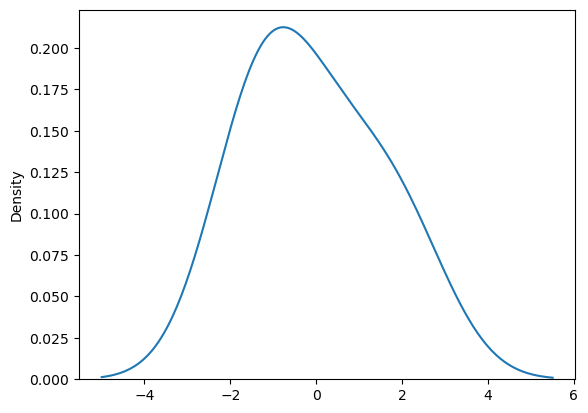

In [12]:
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns

#generate t distribution with sample size 4
x = t.rvs(df=1, size=4)
import seaborn as sns

#create density curve
sns.kdeplot(x)

3. **High Leverage Observations (Unusual X-values)**
  - This observation has the potential to change the model dramatically. However, having a large impact is only a possibility, not a definite.
  - If you have more than one independent variable, you can plot each independent variable in its own histogram or boxplot, or use residual plots, to look for unusual values. The histogram and the residual plot below display the leverage point in the fitted line plot above.
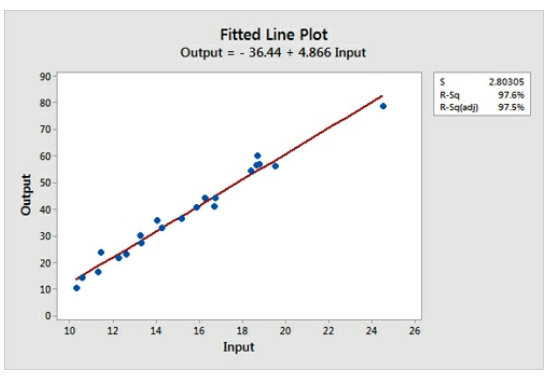
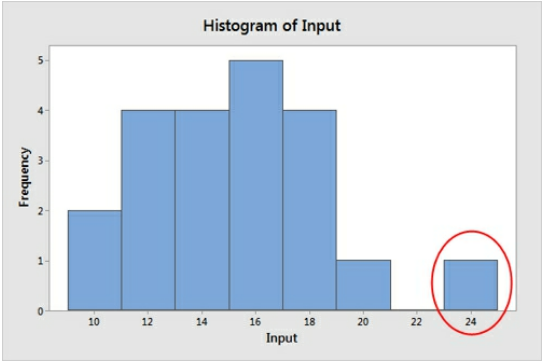
   - Leverage – a data point whose x-value (independent) is unusual, y-value follows the predicted regression line though. A leverage point may look okay as it sits on the predicted regression line. However, a leverage point will inflate the strength of the regression relationship by both the statistical significance (reducing the p-value to increase the chance of a significant relationship) and the practical significance (increasing r-square). Unfortunately, leverage points have no impact on the coefficients because the point follows the predicted regression line

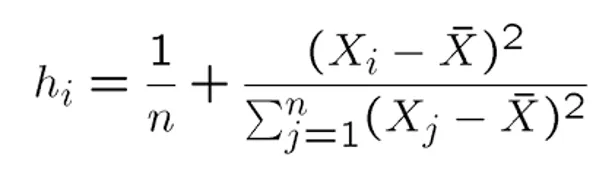
- In the formula, leverage value for some particular observation is represented by hi. In the first term after the equals sign, 1/n, the n represents the number of observations used in the model. In the last term, the (xi — x)2 term in the numerator represents the squared difference between that particular observation and the mean value for the independent variable. Finally, the denominator of that fraction in the last term is the sum of the squared differences from the mean among all the observations in the entire dataset.
- 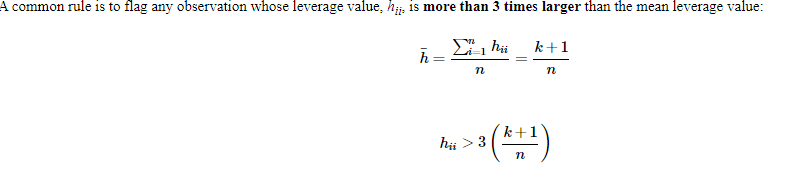

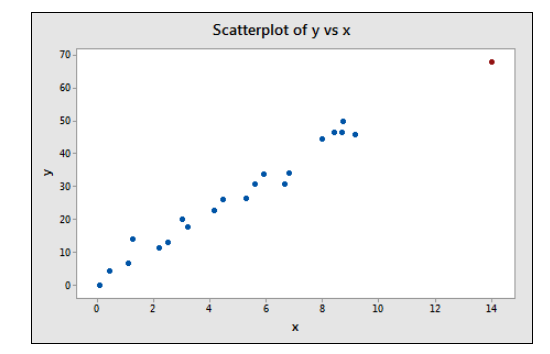

In [25]:
df = pd.read_csv('sheet.csv')
df.head()

Row        x        y
0    1  0.10000  -0.0716
1    2  0.45401   4.1673
2    3  1.09765   6.5703
3    4  1.27936  13.8150
4    5  2.20611  11.4501

In [26]:
df.shape

(21, 3)

In [27]:
df['x'].mean()

5.227245238095238

In [30]:
df['diff']= df['x']-df['x'].mean()
df.head()

Row        x        y      diff
0    1  0.10000  -0.0716 -5.127245
1    2  0.45401   4.1673 -4.773235
2    3  1.09765   6.5703 -4.129595
3    4  1.27936  13.8150 -3.947885
4    5  2.20611  11.4501 -3.021135

In [32]:
df['diff_square']= df['diff']**2
df.head()

Row        x        y      diff  diff_square
0    1  0.10000  -0.0716 -5.127245    26.288644
1    2  0.45401   4.1673 -4.773235    22.783775
2    3  1.09765   6.5703 -4.129595    17.053557
3    4  1.27936  13.8150 -3.947885    15.585798
4    5  2.20611  11.4501 -3.021135     9.127258

In [34]:
df['diff_square'].sum()

248.32932215272382

In [29]:
(14-df['x'].mean())**2

76.96122611252268

In [35]:
h_i= (1/21) + (76.96/248.32) # (14,68)
h_i

0.35754172803141876

- Of course, our intution tells us that the red data point (x = 14, y = 68) is extreme with respect to the other x values. But, is the x value extreme enough to warrant flagging it? Let's see!
- k is number of predictors, x, so 1
- In this case, there are n = 21 data points and k+1 = 2 parameters (the intercept β0 and slope β1). Therefore:
$3((k+1)/n)$=3(221)=0.286
- Now, the leverage of the data point, 0.358, is greater than 0.286. Therefore, the data point should be flagged as having high leverage. 
- Leverages only take into account the extremeness of the x values, but a high leverage observation may or may not actually be influential.

4. A data point is **influential** if it unduly influences any part of a regression analysis, such as the predicted responses, the estimated slope coefficients, or the hypothesis test results. 
- Outliers and high leverage data points have the potential to be influential, but we generally have to investigate further to determine whether or not they are actually influential.
- An easy way to determine if the data point is influential is to find the best fitting line twice — once with the red data point included and once with the red data point excluded. 
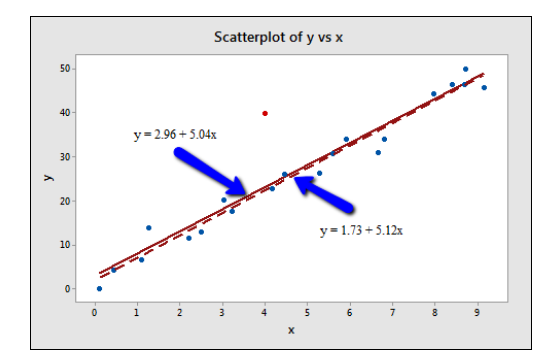
- After testing, the predicted responses, estimated slope coefficients, and hypothesis test results are not affected by the inclusion of the red data point. Therefore, the data point is not deemed influential. In summary, the red data point is not influential and does not have high leverage, but it is an outlier.

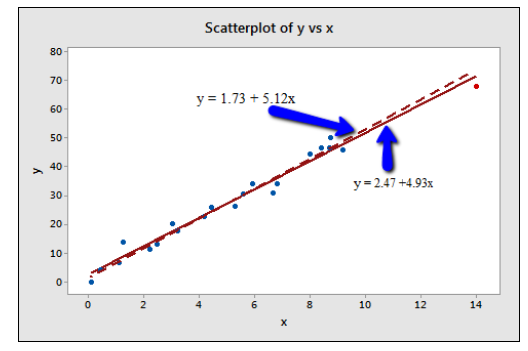
- After testing, estimated slope coefficients, and hypothesis test results are not affected by the inclusion of the red data point. Therefore, the data point is not deemed influential. In summary, the red data point is not influential, nor is it an outlier, but it does have high leverage.

- After testing, the predicted responses and estimated slope coefficients are clearly affected by the presence of the red data point. While the data point did not affect the significance of the hypothesis test, the t-statistic did change dramatically. In this case, the red data point is deemed both high leverage and an outlier, and it turned out to be influential too.

**Identifying Influential Data Points**
- Cook's distance (D): The distance between the coefficients calculated with and without an observation. Higher values represent more influence. 
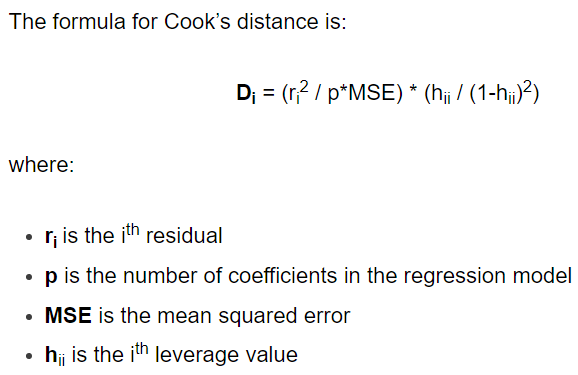
  - Essentially Cook’s distance measures how much all of the fitted values in the model change when the ith observation is deleted.
  - The larger the value for Cook’s distance, the more influential a given observation.
  - A general rule of thumb is that any observation with a Cook’s distance greater than 4/n (where n = total observations) is considered to be highly influential.
- Difference in fits (DFITS): Approximately the number of standard deviations that the fitted values change when an observation is removed from the dataset. Higher values represent more influence.


In [15]:
df = pd.read_csv('sheet2.csv')
df.head()

x  y  y_hat
0  1  2    2.2
1  2  5    4.4
2  3  6    6.6
3  4  9    8.8

In [21]:
import statsmodels.api as sm

#define response variable
y = df['y']

#define explanatory variable
x = df['x']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit() 

#suppress scientific notation
import numpy as np
np.set_printoptions(suppress=True)

#create instance of influence
influence = model.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance

#display Cook's distances
print(cooks[0]) # distance values


[0.38888889 0.2755102  0.2755102  0.38888889]


In [18]:
import matplotlib.pyplot as plt

plt.scatter(df.x, cooks[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

- If distance is greater than 0.5, then the ith data point is worthy of further investigation as it may be influential.
- If distance is greater than 1, then the ith data point is quite likely to be influential.
- Or, if distance sticks out like a sore thumb from the other distance values, it is almost certainly influential.

5. **Multi-collinearity**
- Multicollinearity is when we have predictor variables that are correlated with one another. One of the main concerns of multicollinearity is that it can lead to coefficients being flipped from the direction we expect from simple linear regression.
- There are two basic kinds of multicollinearity: 
  - **Structural multicollinearity**: This type occurs when we create a model term using other terms. In other words, it’s a byproduct of the model that we specify rather than being present in the data itself. For example, if you square term X to model curvature, clearly there is a correlation between X and $X^2$. 
    - Centering the variables is a simple way to reduce structural multicollinearity. Centering the variables involves calculating the mean for each continuous independent variable and then subtracting the mean from all observed values of that variable. Then, use these centered variables in your model. Most statistical software allows you to fit your model using centered variables. There are other standardization methods, but the advantage of just subtracting the mean is that the interpretation of the coefficients remains the same. The coefficients continue to represent the mean change in the dependent variable given a 1-unit change in the independent variable.
  - **Data multicollinearity**: This type of multicollinearity is present in the data itself rather than being an artifact of our model. Observational experiments are more likely to exhibit this kind of multicollinearity.
- One of the most common ways to identify multicollinearity is with bivariate plots or with variance inflation factors (or VIFs).
- Multicollinearity has two potential negative impacts. 
  - The expected relationships between your x-variables and the response may not hold when multicollinearity is present. That is, you may expect a positive relationship between the explanatory variables and the response (based on the bivariate relationships), but in the multiple linear regression case, it turns out the relationship is negative.
  - Our hypothesis testing results may not be reliable. It turns out that having correlated explanatory variables means that our coefficient estimates are less stable. That is, standard deviations (often called standard errors) associated with your regression coefficients are quite large. Therefore, a particular variable might be useful for predicting the response, but because of the relationship it has with other x-variables, you will no longer see this association.
- We have also looked at two different ways of **identifying multicollinearity**:
  - Looking at the correlation of each explanatory variable with each other explanatory variable (with a plot or the correlation coefficient).
  - Looking at VIFs for each variable: VIFs start at 1 and have no upper limit. A value of 1 indicates that there is no correlation between this independent variable and any others. VIFs between 1 and 5 suggest that there is a moderate correlation, but it is not severe enough to warrant corrective measures. VIFs greater than 5 represent critical levels of multicollinearity where the coefficients are poorly estimated, and the p-values are questionable.

- When VIFs are greater than 10, this suggests that multicollinearity is certainly a problem in your model. Some experts even suggest that VIFs greater than 5 can be problematic. In most cases, not just one VIF is high, but rather many VIFs are high, as these are measures of how related variables are with one another.
- The most common way of working with correlated explanatory variables in a multiple linear regression model is simply to remove one of the variables that is most related to the other variables. Choosing an explanatory variable that you aren't interested in, or isn't as important to you, is a common choice.
- **NOTE**: You’ll notice that the standard error of the regression (S), R-squared, adjusted R-squared, and predicted R-squared are all identical for models with and without multicollinearity as multicollinearity doesn’t affect the predictions or goodness-of-fit. If you just want to make predictions, the model with severe multicollinearity is just as good!

6. **All independent variables are uncorrelated with the error term**
- If an independent variable is correlated with the error term, we can use the independent variable to predict the error term, which violates the notion that the error term represents unpredictable random error. We need to find a way to incorporate that information into the regression model itself. This assumption is also referred to as exogeneity. Conversely, when this type of correlation exists, which violates the assumption, there is endogeneity.
- Violating this assumption biases the coefficient estimate. To understand why this bias occurs, keep in mind that the error term always explains some of the variability in the dependent variable. However, when an independent variable is correlated with the error term, OLS incorrectly attributes some of the variance that the error term actually explains to the independent variable instead.
- To check this assumption, graph the residuals by each independent variable. The graph should display that nice randomness I showed earlier. If there is a pattern, your model has a problem.

**Least-squares algorithm** 
- $$\hat{y}= b_0 +b_1*x_1$$
- A line is commonly identified by an intercept and a slope.
- The **intercept** is defined as the predicted value of the response when the x-variable is zero. 
  - The Y-Intercept Might Be Outside of the Observed Data. `weight= -114 + 106.5 *height`Using the traditional definition for the regression constant, if height is zero, the expected mean weight is -114 kilograms!
  - The more variables you have, the less likely it is that each and every one of them can equal zero simultaneously.
  - If the independent variables can’t all equal zero, or you get an impossible negative y-intercept, don’t interpret the value of the y-intercept!
  - The observed relationship is locally linear, but it must curve as it decreases below the observed values. Don’t predict outside the range of your data! This principle is an additional reason why the y-intercept might not be interpretable.
  - A portion of the estimation process for the y-intercept is based on the exclusion of relevant variables from the regression model. When you leave relevant variables out, this can produce bias in the model. Bias exists if the residuals have an overall positive or negative mean. In other words, the model tends to make predictions that are systematically too high or too low. The constant term prevents this overall bias by forcing the residual mean to equal zero. Imagine that you can move the regression line up or down to the point where the residual mean equals zero. For example, if the regression produces residuals with a positive average, just move the line up until the mean equals zero. This process is how the constant ensures that the regression model satisfies the critical assumption that the residual average equals zero. However, this process does not focus on producing a y-intercept that is meaningful for your study area. Instead, it focuses entirely on providing that mean of zero. The constant ensures the residuals don’t have an overall bias, but that might make it meaningless.
  - The reason directly above explains why you should almost always have the constant in your regression model—it forces the residuals to have that crucial zero mean. Furthermore, if you don’t include the constant in your regression model, you are actually setting the constant to equal zero. This action forces the regression line to go through the origin. In other words, a model that doesn’t include the constant requires all of the independent variables and the dependent variable to equal zero simultaneously.
  - When it comes to using and interpreting the constant in a regression model, you should almost always include the constant in your regression model even though it is almost **never worth interpreting.**
  - **Interpreting the Constant When You Center All the Continuous Independent Variables**: centering your variables involves subtracting the mean of each variable from all the values for that variable. Using this approach, zero values for a variable now signify the mean of that variable. If your model contains only continuous independent variables and you center them, the constant represents the average value of the dependent variable when all the continuous variables are at their means.
    -  `weight= 46.33 + 106.5 *height`: The constant indicates that the mean weight is 46.33 kg at the mean height of 1.5 M.
  - If your model contains continuous and categorical independent variables, you’ll need to adjust your interpretation of the constant slightly. Recall that OLS includes categorical variables in the model by using a set of indicator variables. When an observation is at the reference level, all of the indicator variables in the model equal zero. Consequently, when the model includes categorical variables, the constant represents the mean of the dependent variable when: All of the continuous variables are at their means, and All of the categorical variables are at their reference levels.


- The **slope** is defined as the predicted change in the response for every one unit increase in the x-variable.
- The main algorithm used to find the best fit line is called the **least-squares algorithm**, which finds the line that minimizes $$\sum_{i=1}^n(y_i-\hat{y}_i)^2$$



**Higher order terms**
- It's possible to fit linear models that look like non-linear models by adding **higher order terms**, like:
- $$\hat{y}= b_0 +b_1*x_1 + b_2 * x_1^2 + b_3*x_2 + b_4 *x_1*x_2$$
1. Interactions
2. Quadratics
3. Cubics
4. Higher order values

- When working with higher order terms, each time a higher order term is added to a model, a lower order term should be added as well. You've learned that using quadratics and cubics is useful when the relationship between response and explanatory variables is non-linear and represented by a curve or curves.
- When to use interaction terms 
  - Interaction terms tell us how a variable x_1  is related to the response variable y and is dependent on the value of another variable x_2. If the slopes of explanatory variable lines are equal or close to equal, interaction terms are not added.
   - If the slopes are not equal it is an indication that an interaction term should be added to the model.

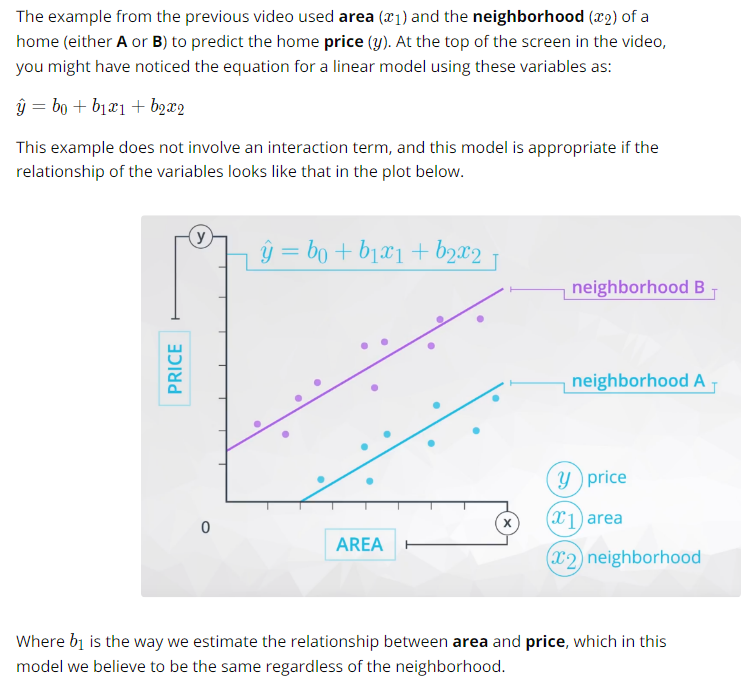

Notice here that:
- The way that area is related to price is the same regardless of the neighborhood.
- The difference in price for the different neighborhoods is the same regardless of the area.
- When these statements are true, we do not need an interaction term in our model.

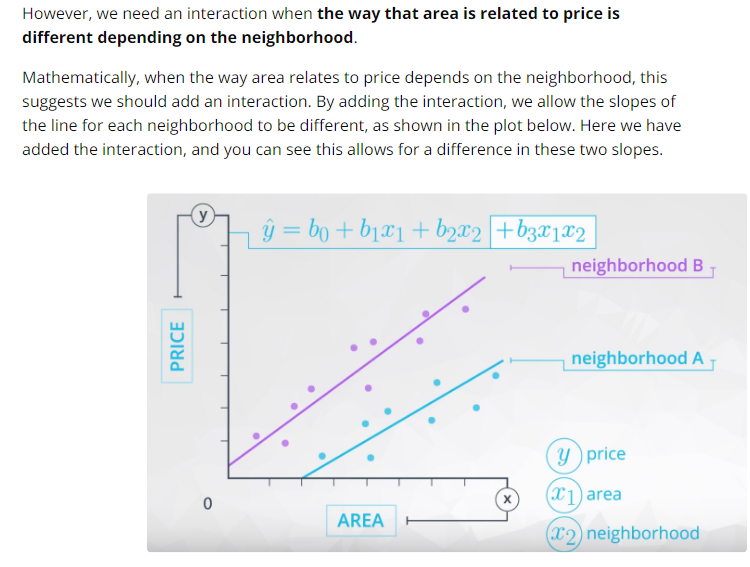

- Specifically, an interaction effect indicates that the relationship between an independent variable and the dependent variable changes based on the value of at least one other independent variable. Those independent variables don’t need to be correlated for that effect to occur.
- For example, suppose that A*B is statistically significant but A and/or B is not significant. In this situation, statisticians typically include both A and B in the model regardless of their statistical significance.
-  

$$(X^′X)^{−1}X′y$$

In [8]:
X= newer_df[['intercept', 'A', 'B', 'ranch', 'victorian', 'area']]
y= newer_df['price']

In [9]:
np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose()), y)

array([-1.98307908e+05, -1.94246412e+02,  5.24266578e+05, -1.97470320e+03,
       -6.26273651e+03,  3.48737541e+02])

# Linear Regression with Python
Your neighbor then gives you some information about a bunch of houses in regions of the United States,it is all in the data set: USA_Housing.csv.

The data contains the following columns:

* 'Avg. Area Income': Avg. Income of residents of the city house is located in.
* 'Avg. Area House Age': Avg Age of Houses in same city
* 'Avg. Area Number of Rooms': Avg Number of Rooms for Houses in same city
* 'Avg. Area Number of Bedrooms': Avg Number of Bedrooms for Houses in same city
* 'Area Population': Population of city house is located in
* 'Price': Price that the house sold at
* 'Address': Address for the house

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

### Check out the Data

In [3]:
df = pd.read_csv('house_prices.csv')
df.head()

house_id neighborhood  area  bedrooms  bathrooms      style    price
0      1112            B  1188         3          2      ranch   598291
1       491            B  3512         5          3  victorian  1744259
2      5952            B  1134         3          2      ranch   571669
3      3525            A  1940         4          2      ranch   493675
4      5108            B  2208         6          4  victorian  1101539

In [4]:
df.head()

house_id neighborhood  area  bedrooms  bathrooms      style    price
0      1112            B  1188         3          2      ranch   598291
1       491            B  3512         5          3  victorian  1744259
2      5952            B  1134         3          2      ranch   571669
3      3525            A  1940         4          2      ranch   493675
4      5108            B  2208         6          4  victorian  1101539

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6028 entries, 0 to 6027
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   house_id      6028 non-null   int64 
 1   neighborhood  6028 non-null   object
 2   area          6028 non-null   int64 
 3   bedrooms      6028 non-null   int64 
 4   bathrooms     6028 non-null   int64 
 5   style         6028 non-null   object
 6   price         6028 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 329.8+ KB


In [6]:
df.describe()

house_id         area     bedrooms    bathrooms         price
count  6028.000000  6028.000000  6028.000000  6028.000000  6.028000e+03
mean   4110.536828  2136.849038     3.717651     2.158261  7.542079e+05
std    2251.834665  1237.481101     1.704650     1.169621  5.236731e+05
min     200.000000     0.000000     0.000000     0.000000  1.216700e+04
25%    2167.500000  1225.000000     3.000000     2.000000  3.641350e+05
50%    4120.500000  1826.000000     4.000000     2.000000  6.357590e+05
75%    6070.250000  3129.000000     5.000000     3.000000  9.666752e+05
max    7999.000000  7447.000000     8.000000     5.000000  3.684602e+06

In [7]:
df.columns

Index(['house_id', 'neighborhood', 'area', 'bedrooms', 'bathrooms', 'style',
       'price'],
      dtype='object')

## One hot encoding
When we add these dummy variables to our multiple linear regression models, we always drop one of the columns. The column you drop is called the baseline. The coefficients you obtain from the output of your multiple linear regression models are then an indication of how the encoded levels compare to the baseline level (the dropped level).

In [8]:
dummies1_df = pd.get_dummies(df['neighborhood'])
dummies2_df = pd.get_dummies(df['style'])
new_df = df.join(dummies1_df)
newer_df = new_df.join(dummies2_df)
newer_df['intercept'] = 1
newer_df.head()

house_id neighborhood  area  bedrooms  bathrooms      style    price  A  B  \
0      1112            B  1188         3          2      ranch   598291  0  1   
1       491            B  3512         5          3  victorian  1744259  0  1   
2      5952            B  1134         3          2      ranch   571669  0  1   
3      3525            A  1940         4          2      ranch   493675  1  0   
4      5108            B  2208         6          4  victorian  1101539  0  1   

   C  lodge  ranch  victorian  intercept  
0  0      0      1          0          1  
1  0      0      0          1          1  
2  0      0      1          0          1  
3  0      0      1          0          1  
4  0      0      0          1          1

In [9]:
newer_df.columns

Index(['house_id', 'neighborhood', 'area', 'bedrooms', 'bathrooms', 'style',
       'price', 'A', 'B', 'C', 'lodge', 'ranch', 'victorian', 'intercept'],
      dtype='object')

## VIFs
Inspect the factors for each predictor variable, if the VIF is between 5-10, multicolinearity is likely present and you should consider dropping the variable.

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [11]:
y, X = dmatrices('price ~ area + intercept+ A +B + ranch + victorian', newer_df, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

C:\Users\SumeetAbhu\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF Factor   features
0    0.000000  Intercept
1    2.025143       area
2    0.000000  intercept
3    1.438137          A
4    1.438016          B
5    1.890372      ranch
6    3.232342  victorian

## Creating and Training the Model - statsmodels

In [12]:
lm2 = sm.OLS(newer_df['price'], newer_df[['intercept', 'A', 'B', 'ranch', 'victorian', 'area']])
results = lm2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.372e+04
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        13:10:42   Log-Likelihood:                -80348.
No. Observations:                6028   AIC:                         1.607e+05
Df Residuals:                    6022   BIC:                         1.607e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.983e+05   5540.744    -35.791      0.000   -2.09e+05   -1.87e+05
A           -194.2464   4965.459     -0.039      0.969   -9928.324    9539.832
B           5.243e+05   4687.484    111.844      0.000    5.15e+05    5.33e+05
ranch      -1974.7032   5757.527     -0.343      0.732   -1.33e+04    9312.111
victorian  -6262.7365   6893.293     -0.909      0.364   -1.98e+04    7250.586
area         348.7375      2.205    158.177      0.000     344.415     353.060
==============================================================================
Omnibus:                      114.369   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.082
Skew:                           0.271   Prob(JB):                     6.29e-31
Kurtosis:                       3.509   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- The predicted difference in the price of a home in neighborhood in A as compared to neighborhood C, holding other variables constant is -194.24
- For every one unit increase in the area of a home, we predict the price of the home to increase by 348.74 (holding all other variables constant)
- The predicted home price is -198400 if the home is a lodge in neighborhood C with an area of 0.
- The predicted difference in price between a victorian and lodge home, holding all other variables constant is lodge is more expensive by 6262.73.

**Interpreting the Results for Categorical Variables**

- The hypotheses for this F-test are the following: 
  - Null: The model with the categorical variable does not improve the fit of the model compared to the model without the categorical variable. 
  - Alternative: The model with the categorical variable fits the data better than the model without the categorical data.
  - Looking at the F-test result in the previous output, we see that 'neighborhood' and 'style'  is statistically significant overall. It improves the fit of the model.
- The hypotheses for these t-tests are the following: 
  - Null: The difference between the level mean and reference level mean equals zero. 
  - Alternative: The difference between the level mean and reference level mean does not equal zero.
  - the difference between mean prices for A and C is not statistically significant. We have insufficient evidence to conclude that these means are different. In other words, the observed difference of $-\$194.24$ might represent random  error. If we were to collect another random sample and perform the analysis again, this difference might vanish.


- C = -1.983e+05 + 349.7* area
- B= (-1.983e+05+5.243e+05) + 349.7* area
- A= (-1.983e+05-194.2464) + 349.7* area

In [13]:
newer_df['area squared'] = newer_df['area']*newer_df['area']

In [14]:
lm = sm.OLS(newer_df['price'], newer_df[['intercept', 'ranch', 'victorian', 'area squared', 'area']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     3173.
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        13:10:42   Log-Likelihood:                -84516.
No. Observations:                6028   AIC:                         1.690e+05
Df Residuals:                    6023   BIC:                         1.691e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     1.855e+04   1.26e+04      1.467      0.142   -6229.316    4.33e+04
ranch         9917.2547   1.27e+04      0.781      0.435    -1.5e+04    3.48e+04
victorian     2509.3957   1.53e+04      0.164      0.870   -2.75e+04    3.25e+04
area squared     0.0029      0.002      1.283      0.199      -0.002       0.007
area           334.0146     13.525     24.696      0.000     307.501     360.528
==============================================================================
Omnibus:                      375.220   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.688
Skew:                           0.519   Prob(JB):                     1.05e-74
Kurtosis:                       2.471   Cond. No.                     4.33e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.33e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- The predicted difference between the price of a ranch home and a lodge, holding all other variables constant is 9917

## Training a Linear Regression Model

Let's now begin to train out regression model! We will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case the Price column. We will toss out the Address column because it only has text info that the linear regression model can't use.

### X and y arrays

In [15]:
X = newer_df[['intercept', 'A', 'B', 'ranch', 'victorian', 'area']]
y = newer_df['price']

In [16]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [17]:
lm.fit(X,y)

LinearRegression()

In [18]:
# print the intercept
print(lm.intercept_)

-198307.908435495


In [19]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

Coefficient
intercept       0.000000
A            -194.246412
B          524266.577789
ranch       -1974.703202
victorian   -6262.736510
area          348.737541

# Training a Linear Regression Model

In [2]:
USAhousing = pd.read_csv('USA_Housing.csv')
USAhousing.head()

Avg. Area Income  Avg. Area House Age  Avg. Area Number of Rooms  \
0      79545.458574             5.682861                   7.009188   
1      79248.642455             6.002900                   6.730821   
2      61287.067179             5.865890                   8.512727   
3      63345.240046             7.188236                   5.586729   
4      59982.197226             5.040555                   7.839388   

   Avg. Area Number of Bedrooms  Area Population         Price  \
0                          4.09     23086.800503  1.059034e+06   
1                          3.09     40173.072174  1.505891e+06   
2                          5.13     36882.159400  1.058988e+06   
3                          3.26     34310.242831  1.260617e+06   
4                          4.23     26354.109472  6.309435e+05   

                                             Address  
0  208 Michael Ferry Apt. 674\nLaurabury, NE 3701...  
1  188 Johnson Views Suite 079\nLake Kathleen, CA...  
2  9127 Elizabeth Stravenue\nDanieltown, WI 06482...  
3                          USS Barnett\nFPO AP 44820  
4                         USNS Raymond\nFPO AE 09386

In [3]:
X = USAhousing[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
               'Avg. Area Number of Bedrooms', 'Area Population']]
y = USAhousing['Price']

## Train Test Split

Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the test set to evaluate the model.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

## Creating and Training the Model - sklearn

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
lm = LinearRegression()

In [8]:
lm.fit(X_train,y_train)

LinearRegression()

In [9]:
# print the intercept
print(lm.intercept_)

-2640159.79685191


In [10]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

Coefficient
Avg. Area Income                  21.528276
Avg. Area House Age           164883.282027
Avg. Area Number of Rooms     122368.678027
Avg. Area Number of Bedrooms    2233.801864
Area Population                   15.150420

In [11]:
coeff_df['Coefficient'][0]

21.528275528904917

In [12]:
print("The linear model is: Y = {:.5} + {:.5}*Avg. Area Income+ {:.5}*Avg. Area House Age + {:.5}*Avg. Area Number of Rooms +{:.5}*Avg. Area Number of Bedrooms {:.5}*Area Population ".format(lm.intercept_,coeff_df['Coefficient'][0], coeff_df['Coefficient'][1], coeff_df['Coefficient'][2], coeff_df['Coefficient'][3], coeff_df['Coefficient'][4]))

The linear model is: Y = -2.6402e+06 + 21.528*Avg. Area Income+ 1.6488e+05*Avg. Area House Age + 1.2237e+05*Avg. Area Number of Rooms +2233.8*Avg. Area Number of Bedrooms 15.15*Area Population 


## Model Evaluation

Let's evaluate the model by checking out it's coefficients and how we can interpret them.
- For any modelling task, the hypothesis is that there is some correlation between the features and the target. The null hypothesis is therefore the opposite: there is no correlation between the features and the target.So, finding the p-value for each coefficient will tell if the variable is statistically significant to predict the target. As a general rule of thumb, if the p-value is less than 0.05: there is a strong relationship between the variable and the target.
- Low p-values (typically < 0.05) indicate that the independent variable is statistically significant. Regression analysis is a form of inferential statistics. Consequently, the p-values help determine whether the relationships that you observe in your sample also exist in the larger population.

Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **Avg. Area Income** is associated with an **average increase of \$21.52**.
- Holding all other features fixed, a 1 unit increase in **Avg. Area House Age** is associated with an **average increase of \$164883.28**.
- Holding all other features fixed, a 1 unit increase in **Avg. Area Number of Rooms** is associated with an **average increase of \$122368.67**.
- Holding all other features fixed, a 1 unit increase in **Avg. Area Number of Bedrooms** is associated with an **average increase of \$2233.80**.
- Holding all other features fixed, a 1 unit increase in **Area Population** is associated with an **average increase of \$15.15**.


## Predictions from our Model

Let's grab predictions off our test set and see how well it did!

In [13]:
predictions = lm.predict(X_test)

In [14]:
plt.scatter(y_test,predictions)

**Residual Histogram**

- The essential parts of a regression model: 
  - Dependent Variable = (Constant +Independent Variables) + Error 
  - Or: Dependent Variable = Deterministic + Stochastic
-  **Deterministic Component**: The deterministic component is the portion of the variation in the dependent variable that the independent variables explain. In other words, the mean of the dependent variable is a function of the independent variables. In a regression model, all of the explanatory power should reside here.
- **Stochastic Error**: Stochastic just means unpredictable. In statistics, the error is the difference between the expected value and the observed value. Let’s put these terms together—the gap between the expected and observed values must not be predictable. Or, no explanatory power should be in the error. If you can use the error to make predictions about the response, your model has a problem. This issue is where residual plots play a role.
  - The theory here is that the deterministic component of a regression model does such a great job of explaining the dependent variable that it leaves only the intrinsically inexplicable portion of your study area for the error. If you can identify non-randomness in the error term, your independent variables are not explaining everything that they can.


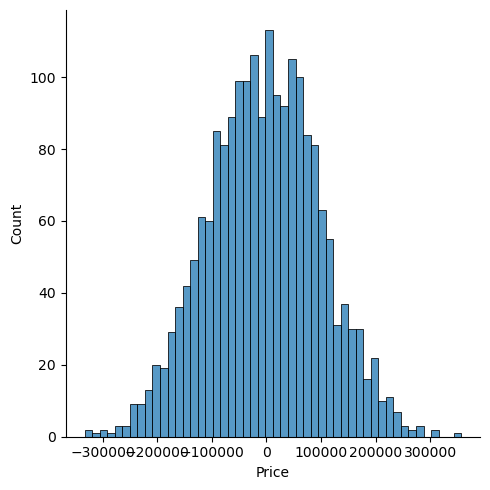

In [15]:
sns.displot((y_test-predictions),bins=50);

OLS does not require that the error term follows a normal distribution to produce unbiased estimates with the minimum variance. However, satisfying this assumption allows you to perform statistical hypothesis testing and generate reliable confidence intervals and prediction intervals.


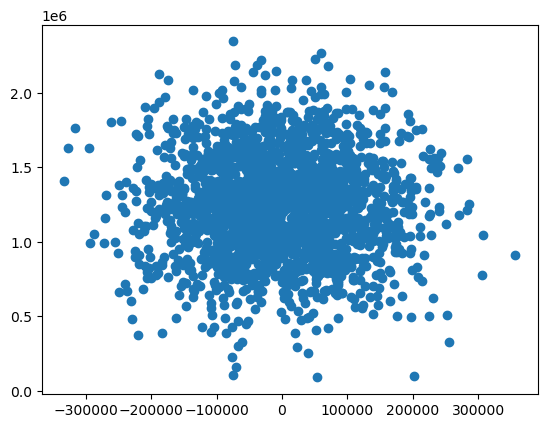

In [16]:
plt.scatter(y_test-predictions, predictions )

# Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:
- Mean Absolute Error is not sensitive to outliers. MAE should be used when you are solving a regression problem and don’t want outliers to play a big role in the prediction. It can be useful if you know that the distribution of data is multimodal.

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:
- A large MSE value means that the data values are dispersed widely around the mean of the data and a small MSE value means that the data values are closely dispersed around the mean. i.e. A model with small MSE value has better performance.

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:
- Unlike MSE, Root Mean Square Error has the same unit of quantity plotted on vertical axis or y-axis. Since square root of the MSE value is taken in RMSE.

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**$R^2$ score** 
- R² score also known as the coefficient of determination gives the measure of how good a model fits to a given dataset. It indicates how closer are the predicted values to the actual values.
- The major drawback of the R² metric is that, as the number of input features for the model increases the R² value also increases irrespective of the significance of the added feature with respect to output variable. i.e. even if the added feature has no correlation with the output variable, the R² value increases.

- RSS + SSE = TSS
- Regression Sum of Squares (RSS): The amount of additional variability your model explains compared to a model that contains no variables and uses only the mean to predict the dependent variable. Higher is usually good. 
- Total Sum of Squares (TSS) = Total Sum of Squares: Overall variability of the dependent variable around its mean.
- Sum of Squared  Errors (SSE):  Overall variability of the distance between the data points and fitted values. Smaller is usually good.
- it measures the proportion of variability in the target that can be explained using a feature X
- The R² value ranges from -∞ to 1. A model with negative R² value indicates that the best fit line is performing worse than the average fit line.
-  R²= RSS/TSS 
- R²= 1- SSE/TSS
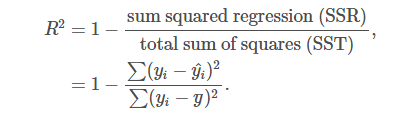
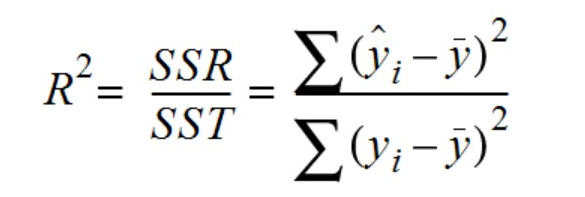
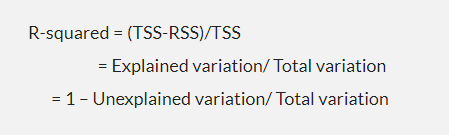
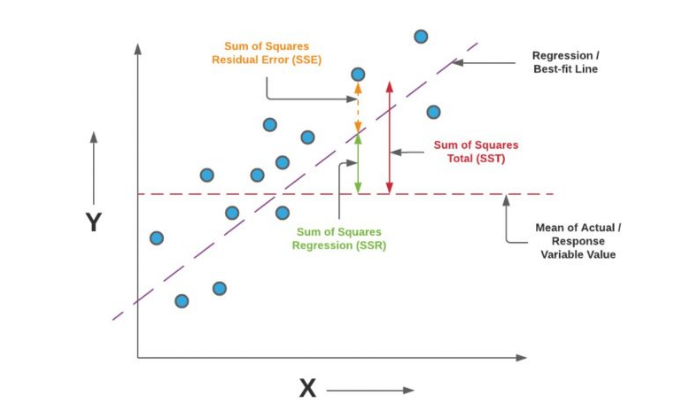
- R-squared is always between 0 and 100%: 
  - 0% represents a model that does not explain any of the variation in the response variable around its mean. The mean of the dependent variable predicts the dependent variable as well as the regression model. 
  - 100% represents a model that explains all of the variation in the response variable around its mean.
- Problem 1: R-squared increases every time you add an independent variable to the model. The R-squared never decreases, not even when it’s just a chance correlation between variables. A regression model that contains more independent variables than another model can look like it provides a better fit merely because it contains more variables.
- Problem 2: When a model contains an excessive number of independent variables and polynomial terms, it becomes overly customized to fit the peculiarities and random noise in your sample rather than reflecting the entire population. Statisticians call this overfitting the model, and it produces deceptively high R-squared values and a decreased capability for precise predictions.


**Adjusted R² Score**
- Adjusted R² is a modified form of R² that penalizes the addition of new independent variable or predictor and only increases if the new independent variable or predictor enhances the model performance.
- n : Number of Samples in our Dataset; k : Number of Predictors
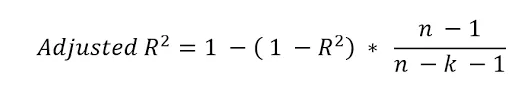

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

**Predicted R-squared**

- This statistic helps you identify cases where the model provides a good fit for the existing data but isn’t as good at making predictions.
- It removes a data point from the dataset.
- Calculates the regression equation. 
- Evaluates how well the model predicts the missing observation. 
- And, repeats this for all data points in the dataset. 
- Predicted R-squared is a summary statistic of how well the model predicted all of the observations when each one was removed from the dataset for an iteration of the above process. Predicted R-squared helps you determine whether you are overfitting a regression model.
- If the predicted R-squared is small compared to R-squared, you might be over-fitting the model even if the independent variables are statistically significant.

**Residual Standard Error**:
- The residual standard error is used to measure how well a regression model fits a dataset. In simple terms, it measures the standard deviation of the residuals in a regression model.
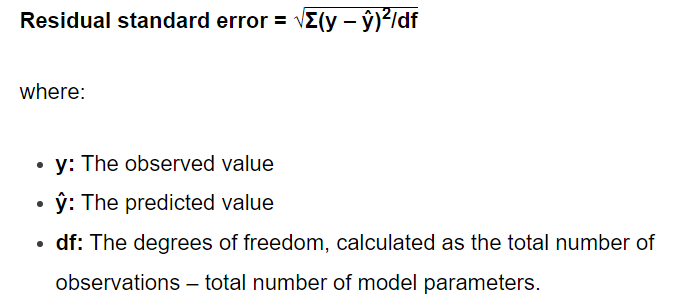

**Rsquare analysis**

- Output1 = 44.53 + 2.024*Input, R square= 14.7%
- Output1 = 44.53 + 2.134*Input, R square= 86.5%
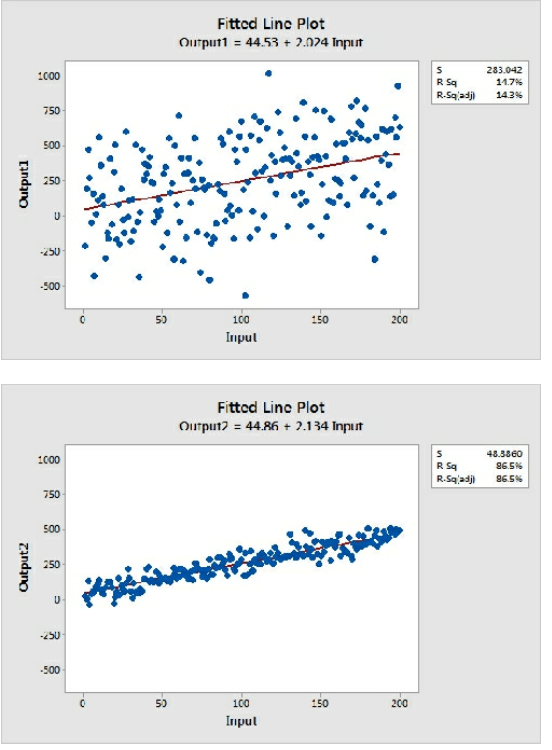

- The models are similar in the following ways: 
    - The equations are nearly equal: Output = 44 + 2 * Input 
    - Input is significant with a p-value
    - Additionally, the regression lines in both plots provide an unbiased fit to the upward trend in both datasets. They have the same upward slope of 2
    - Furthermore, if you enter the same Input value in the two equations, youll obtain approximately equal predicted values for Output. For example, an Input of 10 produces predicted values of 66.2 and 64.8. These values represent the predicted mean value of the dependent variable
- Model differences:
  - The biggest difference between the two models is the variability around those means
  - For a given dataset, higher variability around the regression line produces a lower R-squared value
  - The prediction intervals are very different because they incorporate the variability

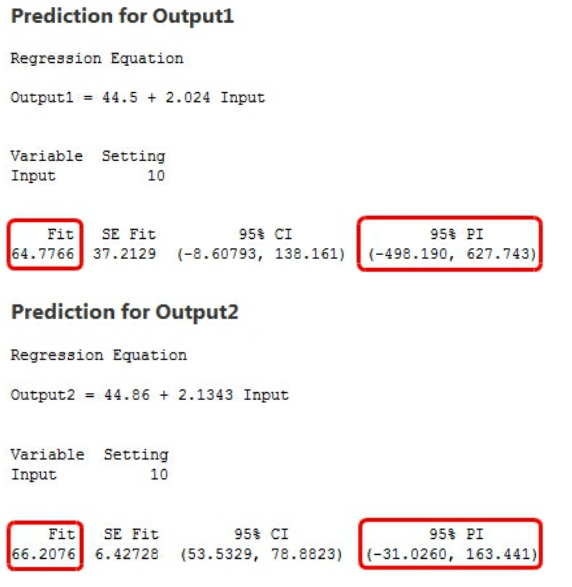

In [17]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R squared:', metrics.r2_score(y_test, predictions))

MAE: 82288.22251914954
MSE: 10460958907.2095
RMSE: 102278.82922291152
R squared: 0.91768240096492


In [18]:
def adjusted_r2_score(actual, predictions, num_pred, num_samples):
    n = num_samples
    k = num_pred
    r2 = metrics.r2_score(actual, predictions)
    adjusted_r2 = 1 - ((1-r2) * ((n-1)/(n-k-1)))
    return adjusted_r2

In [23]:
adjusted_r2_score(y_test, predictions, num_pred=5, num_samples=5000)

0.9175999844660864

- Let’s assume that our predictions must be within +/- 5% of the actual values to be useful. If we know only that R-squared is 76.1%, can we determine whether our model is sufficiently precise? No, you can’t tell using R-squared. However, you can use the standard error of the regression. For our model to have the required precision, S must be less than 2.5% because 2.5 * 2 = 5.
- In an instant, we know that our S (~3.5) is too large. We need a more precise model.

- The F-test for overall significance has the following two hypotheses: 
  - The null hypothesis states that the model with no independent variables fits the data as well as your model. 
  - The alternative hypothesis says that your model fits the data better than the intercept-only model.
- Generally speaking, if none of your independent variables are statistically significant, the overall F-test is also not statistically significant. Occasionally, the t-tests for coefficients and the overall F-test can produce conflicting results. This disagreement can occur because the F-test of overall significance assesses all of the coefficients jointly whereas the t-test for each coefficient examines them individually. For example, the overall F-test can find that the coefficients are significant jointly while the t-tests can fail to find significance individually. These conflicting test results can be hard to understand, but think about it this way. The F-test sums the predictive power of all independent variables and determines that it is unlikely that all of the coefficients equal zero. However, it’s possible that each variable isn’t predictive enough on its own to be statistically significant. In other words, your sample provides sufficient evidence to conclude that your model is significant, but not enough to conclude that any individual variable is significant.


# Recoding Continuous Independent Variables


Feature scaling is a data preprocessing technique that involves transforming the values of features or variables in a dataset to a similar scale. This is done to ensure that all features contribute equally to the model and to prevent features with larger values from dominating the model. Feature scaling is essential when working with datasets where the features have different ranges, units of measurement, or orders of magnitude. Common feature scaling techniques include standardization, normalization, and min-max scaling. 

**Standardizing the Continuous Variables**

- To standardize a variable, you take each observed value for a variable, subtract the variable’s mean, and then divide by the variable’s standard deviation. 
- When you standardize a variable, the coded value denotes where the observation falls in the distribution of values by indicating the number of standard deviations above or below the variable’s mean. 
- The sign indicates whether the observation is above or below the mean, and the number indicates the number of standard deviations.


- When you fit the model using standardized independent variables, the coefficients are now standardized coefficients.
- Standardized coefficients signify the mean change of the dependent variable given a one standard deviation increase in an independent variable.
- **Identifying the Most Important Independent Variables in a Regression Model**
  - Fit the regression model using the standardized independent variables and compare the standardized coefficients. Because they all use the same scale, you can compare them directly. Standardized coefficients signify the mean change of the dependent variable given a one standard deviation shift in an independent variable.
  - Identify the independent variable that produces the largest R-squared increase when it is the last variable added to the model.

# Confounding Variables and Omitted Variable Bias


- For omitted variable bias to occur, the following two conditions must exist: 
  - The omitted variable must correlate with the dependent variable. 
  - The omitted variable must correlate with at least one independent variable that is in the regression model.


Suppose you have a regression model with two significant independent variables, X1 and X2. These independent variables correlate with each other and the dependent variable—which are the requirements for omitted variable bias. Now, imagine that we take variable X2 out of the model. It is the confounding variable. Here’s what happens: 
- The model fits the data less well because we’ve removed a significant explanatory variable. Consequently, the gap between the observed values and the fitted values increases. These gaps are the residuals. 
- The degree to which each residual increases depends on the relationship between X2 and the dependent variable. Consequently, the residuals correlate with X2.
- X1 correlates with X2, and X2 correlates with the residuals. Ergo, variable X1 correlates with the residuals.
- Hence, this condition violates the ordinary least squares assumption that independent variables in the model do not correlate with the residuals. Violations of this assumption produce biased estimates.



**How to Detect Omitted Variable Bias and Identify Confounding Variables**

In the previous example, I started with a regression model that has activity as the lone independent variable and bone density as the dependent variable. After adding weight to the model, the correlation changed from zero to positive. However, if we don’t have the data, it can be harder to detect omitted variable bias. If my study hadn’t collected the weight data, the answer would not be as clear. I presented a clue earlier in this section. We know that for omitted variable bias to exist, an independent variable must correlate with the residuals. Consequently, we can plot the residuals by the variables in our model. If we see a relationship in the plot, rather than random scatter, it both tells us that there is a problem and points us towards the solution. We know which independent variable correlates correlates with the confounding variable. That knowledge might help you track down the problem.

**Obstacles to Correcting Omitted Variable Bias**

- Because the bias occurs when the confounding variables correlate with independent variables, including these confounders invariably introduces multicollinearity into your model. Multicollinearity causes its own problems including unstable coefficient estimates, lower statistical power, and less precise estimates. 
- It’s important to note a tradeoff that might occur between precision and bias. As you include the formerly omitted variables, you lessen the bias, but the increased multicollinearity can potentially reduce the precision of the estimates.
- To track the precision, check the confidence intervals of the coefficient estimates. If the intervals become wider, the estimates are less precise. In the end, you might accept a little bias if it significantly improves precision.
- If you absolutely cannot include an important variable and it causes omitted variable bias, consider using a proxy variable. Typically, proxy variables are easy to measure, and analysts use them instead of variables that are either impossible or difficult to measure. The proxy variable can be a characteristic that is not of any great importance itself, but has a good correlation with the confounding variable.

# Automated Variable Selection Procedures


# Wrapper methods

- **Forward selection** — starts with one predictor and adds more iteratively. At each subsequent iteration, the best of the remaining original predictors are added based on performance criteria.
- **Backward elimination** — starts with all predictors and eliminates one-by-one iteratively. One of the most popular algorithms is Recursive Feature Elimination (RFE) which eliminates less important predictors based on feature importance ranking.
- **Step-wise selection** — bi-directional, based on a combination of forward selection and backward elimination. It is considered less greedy than the previous two procedures since it does reconsider adding predictors back into the model that has been removed (and vice versa). Nonetheless, the considerations are still made based on local optimisation at any given iteration.

In [3]:
pip install mlxtend

     ---------------------------------------- 1.4/1.4 MB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
#Load needed libraries
from sklearn.datasets import load_boston
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# load_boston() sklearn dataset to boston
boston = load_boston()

# use np.c_ to concatenate into a dataframe
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['PRICE'] = pd.Series(boston.target)

#Split the features and target data
#select the first 13 columns as features
X = df.iloc[:,:13]
#Select the last column for target 
y = df.iloc[:,-1]

#Define Sequential Forward Selection (sfs)
sfs = SFS(LinearRegression(),
           k_features=5,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 5 features 
sfs.fit(X, y)

#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results

feature_idx             cv_scores avg_score  \
1              (12,)  [0.5441462975864799]  0.544146   
2            (5, 12)  [0.6385616062603404]  0.638562   
3        (5, 10, 12)  [0.6786241601613112]  0.678624   
4     (5, 7, 10, 12)  [0.6903077016842538]  0.690308   
5  (4, 5, 7, 10, 12)  [0.7080892893529661]  0.708089   

                    feature_names  
1                        (LSTAT,)  
2                     (RM, LSTAT)  
3            (RM, PTRATIO, LSTAT)  
4       (RM, DIS, PTRATIO, LSTAT)  
5  (NOX, RM, DIS, PTRATIO, LSTAT)

SequentialFeatureSelector() class accepts the following major parameters:

- `LinearRegression()` acts as an estimator for the feature selection process. Alternatively, it can be substituted with other regression or classification based algorithm.
- `k_features` indicates the number of features to be selected. For demonstration purposes, 5 features are selected from the original 13. This value can be optimized by analyzing the scores for different numbers of features.
- `forward` indicates the direction of the wrapper method used. forward = True for forward selection whereas forward = False for backward elimination.
- `Scoring` argument specifies the evaluation criterion to be used. For regression problems, r2 score is the default and only implementation. But for classification, there are options for accuracy, precision, recall, f1-score, etc.
- `cv` argument is for k-fold cross-validation. Be default, it will be set as 5. Bear in mind, a larger number of cross-validation can be time-consuming and computing-intensive.

In [21]:
#Load needed libraries
from sklearn.datasets import load_boston
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# load_boston() sklearn dataset to boston
boston = load_boston()

#Split the features and target data
#select the first 13 columns as features
X = boston.data
#Select the last column for target 
Y = boston.target

#Build a logistic regression model 
model = LinearRegression()

#Define RFE 
rfe = RFE(estimator=model, n_features_to_select=5)
#Use RFE to select the top 5 features 
fit= rfe.fit(X, Y)

#Create a dataframe for the results 
df_RFE_results = []
for i in range(X.shape[1]):
    df_RFE_results.append(
        {      
            'Feature_names': boston.feature_names[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
        }
    )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name='Columns'
df_RFE_results

Feature_names  Selected  RFE_ranking
Columns                                     
0                CRIM     False            4
1                  ZN     False            6
2               INDUS     False            5
3                CHAS      True            1
4                 NOX      True            1
5                  RM      True            1
6                 AGE     False            9
7                 DIS      True            1
8                 RAD     False            3
9                 TAX     False            7
10            PTRATIO      True            1
11                  B     False            8
12              LSTAT     False            2

In [15]:
#Load needed libraries
from sklearn.datasets import load_boston
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# load_boston() sklearn dataset to boston
boston = load_boston()

# use np.c_ to concatenate into a dataframe
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['PRICE'] = pd.Series(boston.target)

#Split the features and target data
#select the first 13 columns as features
X = df.iloc[:,:13].values
#Select the last column for target 
y = df.iloc[:,-1].values

#Define Sequential Forward Selection (sfs)
sffs = SFS(LinearRegression(),
           k_features=5,
           forward=True,
           floating=True,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 5 features 
feature_names=boston.feature_names
sffs.fit(X, y)

#Create a dataframe for the SFS results 
df_SFFS_results = pd.DataFrame(sffs.subsets_).transpose()
df_SFFS_results

feature_idx             cv_scores avg_score      feature_names
1              (12,)  [0.5441462975864799]  0.544146              (12,)
2            (5, 12)  [0.6385616062603404]  0.638562            (5, 12)
3        (5, 10, 12)  [0.6786241601613112]  0.678624        (5, 10, 12)
4     (5, 7, 10, 12)  [0.6903077016842538]  0.690308     (5, 7, 10, 12)
5  (4, 5, 7, 10, 12)  [0.7080892893529661]  0.708089  (4, 5, 7, 10, 12)

Similar to the class used in 1. Forward Selection, the parameters used are the same, with the exception:

- `floating`: arguments add a conditional exclusion/inclusion of features to create a bi-directional selection. When forward = True, that means with every forward iteration (in Sequential Forward Selection), it also considers excluding feature(s) in the previous iteration to optimize performance. Vice versa for Backward Elimination to include feature(s) in the existing subset.

# What is the ideal number of features?

In [16]:
#Load needed libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

#import and prepare data
boston = load_boston()
X, y = boston.data, boston.target

#Define Sequential Forward Selection (sfs)
sfs = SFS(LinearRegression(), 
          k_features=13, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=5)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

As seen in the graph, the performance peaks at 7 features with `5-fold cross-validation (cv=5)`. Not to be confused with the negative signs for performance, `neg_mean_squared_error` simply multiplies the result of mean squared error (MSE) with -1 just to follow the convention of that sklearn. The idea is that minimizing MSE is equivalent to maximizing negative-MSE

- Automatic variable selection procedures are algorithms that pick the variables to include in your regression model. Stepwise regression and Best Subsets regression are two of the more common variable selection methods.

- How Stepwise Regression Works?
  - As the name stepwise regression suggests, this procedure selects variables in a step-by-step manner. This procedure begins with a set of candidate independent variables and then adds or removes independent variables one at a time using the variable’s statistical significance. Stepwise either adds the most significant variable or removes the least significant variable. It does not consider all possible models, and it produces a single regression model when the algorithm ends.
  - Typically, you can control the specifics of the stepwise procedure. For example, you can specify whether it can only add variables, only remove variables, or both. You can also set the significance level for including and excluding the independent variables.

- How Best Subsets Regression Works?
  - Best subsets regression is also known as “all possible regressions” and “all possible models.” Again, the name of the procedure indicates how it works. Unlike stepwise, best subsets regression fits all possible models based on the independent variables that you specify. 
  - The number of models that this procedure fits multiplies quickly. If you have 10 independent variables, it fits 1024 models. However, if you have 20 variables, it fits 1,048,576 models! Best subsets regression fits 2P models, where P is the number of predictors in the dataset.
  - After fitting all of the models, best subsets regression then displays the best fitting models with one independent variable, two variables, three variables, and so on. Usually, either adjusted R-squared or Mallows Cp is the criterion for picking the best fitting models for this process.

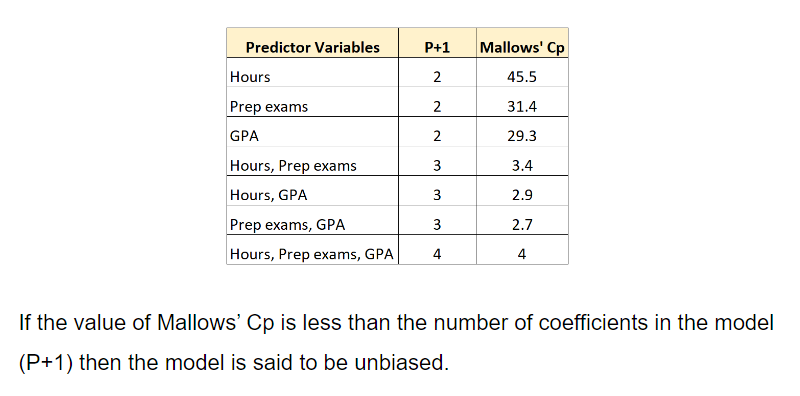

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from itertools import permutations
import pandas as pd

In [48]:
df = pd.read_csv('Credit.csv', usecols=list(range(1,12)))
df.head()

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   
3  148.924   9504     681      3   36         11  Female      No      No   
4   55.882   4897     357      2   68         16    Male      No     Yes   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580  
3      Asian      964  
4  Caucasian      331

In [32]:
df.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender',
       'Student', 'Married', 'Ethnicity', 'Balance'],
      dtype='object')

In [34]:
df= pd.get_dummies(df, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)
df.head()

Income  Limit  Rating  Cards  Age  Education  Balance  Gender_Female  \
0   14.891   3606     283      2   34         11      333              0   
1  106.025   6645     483      3   82         15      903              1   
2  104.593   7075     514      4   71         11      580              0   
3  148.924   9504     681      3   36         11      964              1   
4   55.882   4897     357      2   68         16      331              0   

   Student_Yes  Married_Yes  Ethnicity_Asian  Ethnicity_Caucasian  
0            0            1                0                    1  
1            1            1                1                    0  
2            0            0                1                    0  
3            0            0                1                    0  
4            0            1                0                    1

**Best subset selection**:
- To perform best selection, we fit separate models for each possible combination of the n  predictors and then select the best subset. That is we fit:
  - All models that contains exactly one predictor
  - All models that contain 2 predictors at the second step: (n choose 2)
  - Until reaching the end point where all n  predictors are included in the model
- This results in $2^n$  possibilities as this is a power set problem. In our case there are $2^{11}$=2048 possible combinations

**Algorithm**
- Let $M_0$  denote the null model which contains no predictors, this model simply predicts the sample mean of each observation
- For k=1,2,...,n: 
  - Fit all (n choose k) models that contain exactly k predictors
  - Pick the best among these (n choose k) models, and call it $M_k$. Here the best is defined as having the smallest RSS, or an equivalent measure 
  - Select the single best model among M0,M1,...,Mn  using cross validated predicton error, Cp , BIC, adjusted R2  or any other method.

1. Suppose we have a dataset with p = 3 predictor variables and one response variable, y. To perform best subset selection with this dataset, we would fit the following 2p = 23 = 8 models:

- A model with no predictors
- A model with predictor x1
- A model with predictor x2
- A model with predictor x3
- A model with predictors x1, x2
- A model with predictors x1, x3
- A model with predictors x2, x3
- A model with predictors x1, x2, x3

2. Next, we’d choose the model with the highest R2 among each set of models with k predictors. For example, we might end up choosing:

- A model with no predictors
- A model with predictor x2
- A model with predictors x1, x2
- A model with predictors x1, x2, x3

3. Next, we’d perform cross-validation and choose the best model to be the one that results in the lowest prediction error, Cp, BIC, AIC, or adjusted R2. For example, we might end up choosing the following model as the “best” model because it produced the lowest cross-validated prediction error:

- A model with predictors x1, x2

Coefficients having p-values less than alpha are statistically significant. For example, if you chose alpha to be 0.05, coefficients having a p-value of 0.05 or less would be statistically significant (i.e., you can reject the null hypothesis and say that the coefficient is significantly different from 0)

In [38]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

- Statisticians have conducted simulation studies which indicate you should have at least 10-15 observations for each term in a linear model. The number of terms in a model is the sum of all the independent variables, their interactions, and polynomial terms to model curvature.
- For instance, if the regression model has two independent variables and their interaction term, you have three terms and need 30-45 observations. Although, if the model has multicollinearity or if the effect size is small, you might require more observations.


# Log-Log Regression Models

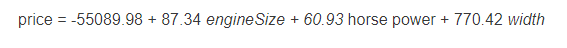

- How can I estimate the price changes using a common unit of comparison?
- How elastic is the price with respect to engine size, horse power, and width?

- $y = b^x$=> log(y) = x log (b)
- Logarithm of e is 1 i.e. log(e) = 1
- Derivative of log(x) is : 1/x
- First, let us define relationship between y and x as an exponential relationship- #1: $y = α *x^β$
- Let us first express this as a function of log-log: log(y) = log(α) + β.log(x)
- Doesn’t equation #1 look similar to regression model: Y= β0 + β1 . x1 ? where β0 = log(α); β1 = β. 
- This equation can be now rewritten as: log(y) = β0 + β1. log(x1)
- But how does it represent elasticity? Let us take derivative of log(y) wrt x, we get the following:
- $d. log(y)/ dx = β1. log(x1)/dx.=> 1/y . dy/dx = β1 . 1/x => β1 = x/y . dy/dx$: The equation of β1 is the elasticity.

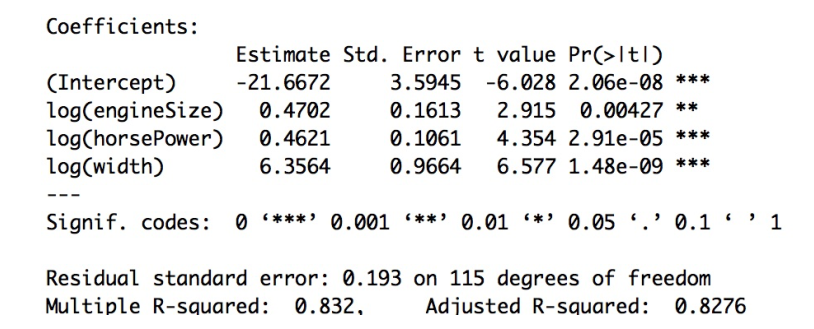

- All coefficients are significant.
- Adjusted r-squared is 0.8276 => the model explains 82.76% of variation in data.
- If the engine size increases by 4.7% then the price of the car increases by 10%.
- If the horse power increases by 4.62% then the price of the car increases by 10%.
- If the width of the car increases by 6% then the price of the car increases by 1 %.
- $e^{log(price)} = price$

# Regression Regularization Techniques — Ridge and Lasso

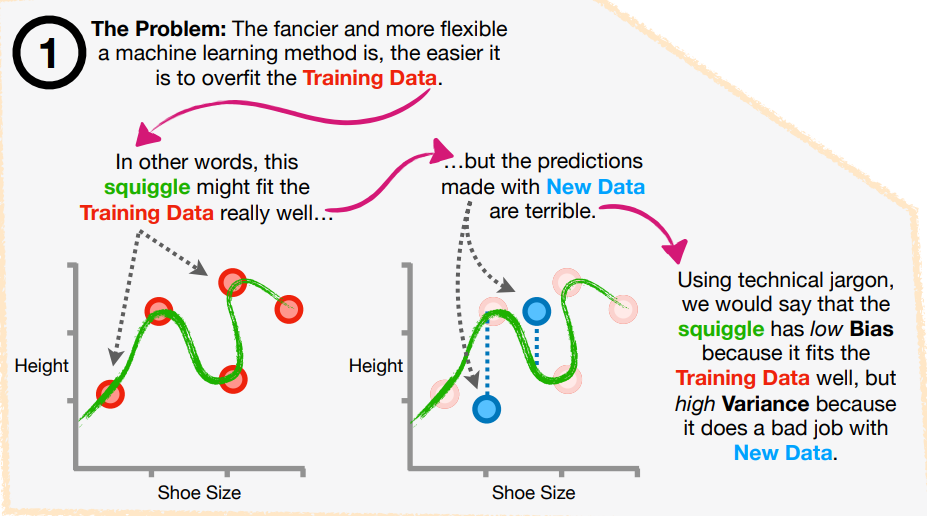

Take a look at this graph that shows Variance and Bias for different Model Complexities. 
- A model with Low Complexity or a Simple Model would have High Bias and Low Variance and a Highly Complex Model would usually have Low Bias and High Variance. 
- Also, note that the Total Error (Bias + Variance) of the model in the case of both a very Simple Model and a highly Complex Model will be Maximum.

- So it is now safe to say that we would be needing a model to be built that has the Lowest Total Error — A model that is capable of identifying all the patterns from the Train Data and also performing well on data it has not seen before i.e. Test Data.

**How does Regularization help with Model Complexity?**
- Regularization comes into the picture when we need to take care of the model complexity to balance Bias-Variance. - Regularization helps decrease the magnitude of the model coefficients towards 0 (can also help in completely removing the feature from the model when coefficient become 0) thus bringing down the model complexity. This will in turn reduce the overfitting of the model and bring down the Total Error — exactly what we wanted to achieve.
- $RSS= $$\sum_{i=1}^n(y_i-\hat{y}_i)^2$
- When we build a Regression Model, we construct the feature coefficients in such a way that the Cost Function or the RSS is minimum. Note that this RSS takes into account only the Bias that comes out of the model and not the Variance. So the model may try to reduce the Bias and overfit the training dataset — Which will result in the model having High Variance.
- After Regularization, Cost Function becomes `RSS + Penalty` i.e. we add a Penalty term to the regular RSS in the cost function.
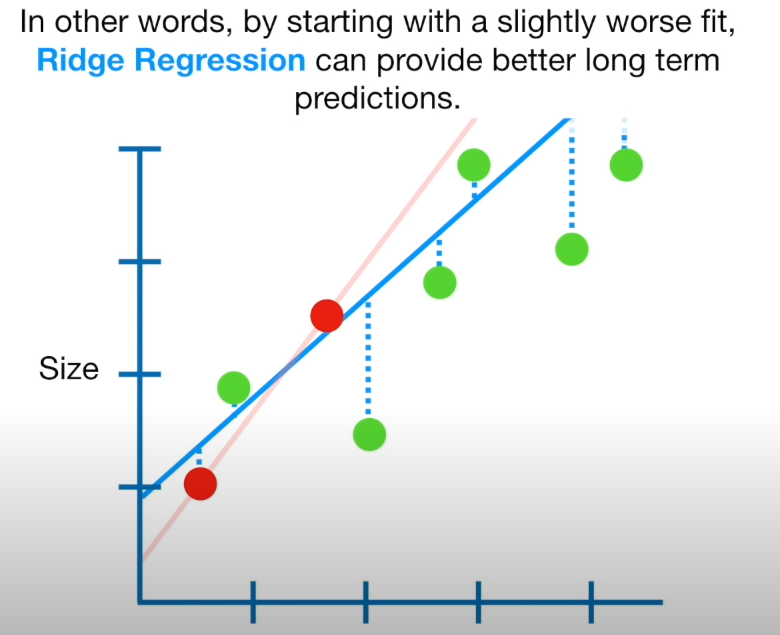

# Ridge Regression
- It is resistant to overlearning.
- It is biased but has a low variance.
- It is better than the Least Squares method when there are too many parameters.
- It offers a solution against multidimensionality. The problem here is that the number of variables is greater than the number of observations. It offers a solution against this.
- It is effective in multiple linear connection problem. The problem here is that there is a high correlation between the independent variables.
- It is important to find an optimum value for λ. Cross-Validation is used for this.

- λ is the Tuning Parameter. Assigning 0 to λ will make the entire Penalty Term 0 and the model coefficients will not be reduced (No Shrinkage) leading to Overfitting. But when λ reaches very high values, the Penalty Term also increases thus bringing down the model coefficients and might cause Underfitting.
- This is why we must choose the right value of λ to make sure the Model Complexity is effectively reduced but there is no Overfitting or Underfitting. **Choosing the right λ value in Ridge Regression can be done by Hyperparameter Tuning**.
- Please note that before performing Ridge Regression, the dataset must be **Standardized**. This is because we are dealing with the coefficients of the model and it will make sense if they are on the same scale.
- As we continue to increase λ, the slope gets closer and closer to 0 and the y-axis intercept becomes the average dependent variable in the Training Dataset. In other words, independent variable no longer plays a significant role in making predictions. Instead, we just use the mean dependent variable.
- The Ridge Penalty never includes the intercept because the intercept doesn’t directly affect how any of the variables (Weight, Shoe Size, or Age) predict Height.
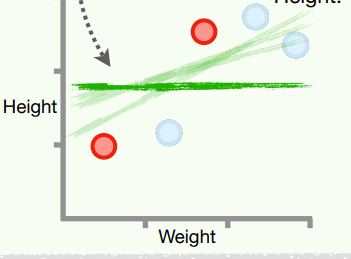


**Steps of Ridge Regression**
- The λ setting parameter is determined by the user.
- Beta coefficients are calculated from the data set.
- A set containing specific values for λ is selected. And Cross-Validation test error is calculated for each.
- The λ, which gives the smallest Cross-Validation, is chosen as the setting parameter.
- Finally, the model is re-fitted with this λ selected.

# Lasso Regression
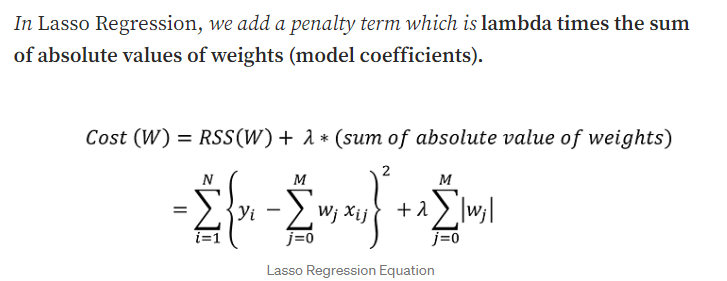

- But one difference that must be noted here is that in the case of Lasso Regression the Shrinkage Term(Penalty Term) forces some of the model **coefficients to become exactly 0** thereby removing the entire feature from the model (given that the λ value is large enough). This gives a whole new application of Lasso Regression — **Feature Selection**. This is not possible in case of Ridge Regression.
- Please note that similar to Ridge Regression, before performing Lasso Regression, the dataset must be **Standardized**. This is because we are dealing with the coefficients of the model and it will make sense if they are on the same scale.

# Train/Test Split and Cross Validation in Python

**Train/test split does have its dangers** 
- What if the split we make isn’t random? 
- What if one subset of our data has only people from a certain state, employees with a certain income level but not other income levels, only women or only people at a certain age? (imagine a file ordered by one of these). 
- This will result in overfitting, even though we’re trying to avoid it! This is where cross validation comes in.
- In order to avoid this, we can perform something called **cross validation**.
- It’s very similar to train/test split, but it’s applied to more subsets. Meaning, we split our data into k subsets, and train on k-1 one of those subset. What we do is to hold the last subset for test. We’re able to do it for each of the subsets.
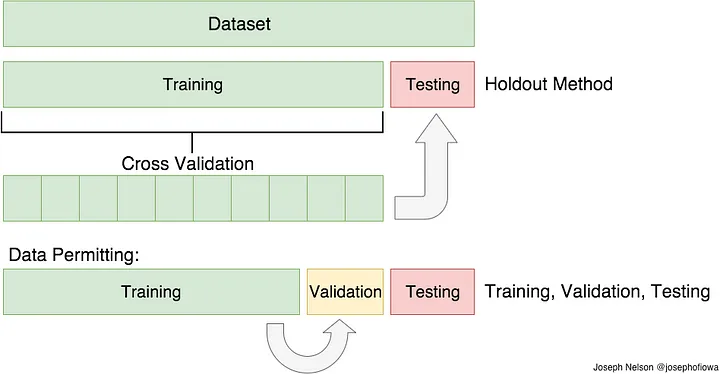

**K-Folds Cross Validation**
- In K-Folds Cross Validation we split our data into k different subsets (or folds). We use k-1 subsets to train our data and leave the last subset (or the last fold) as test data. We then average the model against each of the folds and then finalize our model. After that we test it against the test set.

- Remark 1: The splitting process is done without replacement. So, each observation will be used for training and validation exactly once.
- Remark 2: Good standard values for k in k-fold cross-validation are 5 and 10. However, the value of k depends on the size of the dataset. For small datasets, we can use higher values for k. However, larger values of k will also increase the runtime of the cross-validation algorithm and the computational cost.
- Remark 3: When k=5, 20% of the test set is held back each time. When k=10, 10% of the test set is held back each time and so on…
- Remark 4: A special case of k-fold cross-validation is the Leave-one-out cross-validation (LOOCV) method in which we set k=n (number of observations in the dataset). Only one training sample is used for testing during each iteration. This method is very useful when working with very small datasets.

In [1]:
import numpy as np
import pandas as pd 

df = pd.read_csv("bike_rentals.csv")
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                   test_size=0.20, random_state=42)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ", np.round(rmse, 2))

RMSE:  824.33


After running the above code block, we get RMSE of 824.33. But this value depends on how we split our data into X_train and y_train. Here, we set random_state=42. According to that value, we obtained RMSE of 824.33. If we set random_state=0, we will obtain RMSE of 909.81. If we set random_state=35, we will get RMSE of 794.15. The reason behind getting different RMSE values is that each time we call the train_test_split function with different values of the random_state hyperparameter, it provides different sets of observations for X_train and X_test. So, what value do we accept as the RMSE? Is it 824.33, 909.81, 794.15 or any other value? As a solution to that problem, one would suggest that we could train the model several times with different values of random_state and then get the average RMSE value. But instead of doing this manually, we can automate this process using the Scikit-learn cross_val_score function.

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
X_shuffle, y_shuffle = shuffle(X, y, random_state=42)

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_shuffle, y_shuffle,
                         scoring="neg_mean_squared_error",
                         cv=cv, n_jobs=1)
rmse = np.sqrt(-scores)
print("RMSE values: ", np.round(rmse, 2))
print("RMSE average: ", np.mean(rmse))

RMSE values:  [ 840.36  901.83 1002.09  833.33  854.99  957.58  897.99  908.51  780.95
  915.89]
RMSE average:  889.3526031728852


In k-fold cross-validation, we make an assumption that all observations in the dataset are nicely distributed in a way that the data are not biased. That is why we first shuffle the dataset using the shuffle function. Then we call the cross_val_score function. Note that we provide the whole dataset to this function. Here, we do not need to provide the split data as X_train, y_train because the splitting is done internally during the process. The cv hyperparameter represents the number of folds (here it is 5). By providing appropriate values to n_jobs, we can do parallel computations. We can distribute the evaluation of the different folds across multiple CPUs on our computer. If we set the n_jobs to 1, only one CPU will be used to evaluate the performances. However, by setting n_jobs=2, we could distribute the process of cross-validation to two CPUs. Finally, by setting n_jobs=-1, we can use all available CPUs on our computer to do the computation in parallel. This is a very effective way, especially when we have a large dataset and when we set cv to a large number, for example, 10.

**Leave One Out Cross Validation (LOOCV)**
- In this type of cross validation, the number of folds (subsets) equals to the number of observations we have in the dataset. We then average ALL of these folds and build our model with the average. We then test the model against the last fold. Because we would get a big number of training sets (equals to the number of samples), this method is very computationally expensive and should be used on small datasets. If the dataset is big, it would most likely be better to use a different method, like kfold.


In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut
X_shuffle, y_shuffle = shuffle(X, y, random_state=42)

#define cross-validation method to use
cv = LeaveOneOut()

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_shuffle, y_shuffle,
                         scoring="neg_mean_squared_error",
                         cv=cv, n_jobs=1)
rmse = np.sqrt(-scores)
print("RMSE values: ", np.round(rmse, 2))
print("RMSE average: ", np.mean(rmse))

RMSE values:  [3.30460e+02 9.09800e+01 8.76040e+02 1.57893e+03 9.09510e+02 1.09900e+01
 7.78340e+02 1.82530e+02 3.19510e+02 5.74860e+02 1.06569e+03 9.89530e+02
 8.48810e+02 5.90300e+01 3.79200e+02 4.30320e+02 4.05070e+02 6.53200e+02
 4.74540e+02 5.91900e+02 5.56820e+02 2.70610e+03 2.46610e+02 3.98110e+02
 5.33200e+02 4.33460e+02 1.00170e+02 7.76070e+02 3.58270e+02 2.16140e+02
 4.08780e+02 4.42370e+02 2.87180e+02 1.07176e+03 4.73850e+02 1.56930e+03
 7.76280e+02 7.89000e+00 3.70850e+02 2.53200e+02 5.78600e+01 1.36220e+02
 2.25620e+02 1.32140e+03 2.39240e+02 1.53158e+03 6.57740e+02 2.27060e+02
 1.95120e+02 9.03050e+02 4.35000e+01 3.20070e+02 9.36060e+02 1.29743e+03
 1.50910e+02 3.67520e+02 1.92436e+03 7.04680e+02 1.03968e+03 1.81860e+02
 8.45380e+02 9.57580e+02 5.93400e+02 8.42670e+02 5.40110e+02 1.04805e+03
 1.55300e+02 1.04589e+03 2.44770e+02 9.02250e+02 1.79950e+02 7.75980e+02
 5.39220e+02 7.93390e+02 2.10400e+02 6.98080e+02 2.90910e+02 6.76350e+02
 2.66920e+02 8.33900e+02 3.20480e+02 